# **TITOLO DEL PROGETTO: CROSS-SELLING DI POLIZZE ASSICURATIVE**

- **DATA DI CONSEGNA** : 19/02/2025
- **VERSIONE** : 1a consegna
- **STUDENTE PROFESSION AI** : Luca Marletta


**LINK UTILI**:
- https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

- https://www.iguazio.com/glossary/classification-threshold/

- https://learn.profession.ai/path-player?courseid=progetto-fondamenti-di-machine-learning&unit=67050a1e4cd3024a2d06401eUnit

-  https://datatab.net/

- https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv

# 1 **IMPORT LIBRERIE**

In [ ]:
#import librerie
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut, train_test_split, learning_curve
from sklearn.datasets import make_regression, make_classification, make_blobs
from sklearn.metrics import mean_squared_error,mean_absolute_error, root_mean_squared_error, r2_score, log_loss, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, RocCurveDisplay, roc_auc_score, auc, PrecisionRecallDisplay
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import cdist
from scipy.stats import pointbiserialr, skewtest, ttest_ind, chi2_contingency, pearsonr, stats, shapiro, kstest
import statsmodels.api as sm #studiare regressione logistica fra variabile numerica e dicotomica (0/1)
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline   # Usa make_pipeline di imblearn per supportare il resampling
import warnings
RANDOM_SEED=0



**Definizione delle Funzioni utili**

In [ ]:
#visualizziamo la matrice di confusione
def plot_confusion_matrix(y_true,
                          y_pred,
                          labels=["Negative","Positive"],show_precision_recall=False):
  cm = confusion_matrix(y_true, y_pred)  #tn,fp,fn,tp
  df_cm = pd.DataFrame(cm,
                       index = labels,
                       columns = ["Predicted"+labels[0],"Predicted"+labels[1]])
  sns.heatmap(df_cm, annot=True, fmt="g")  #<- con fmt="g" NO alla notazione scientifica

  if show_precision_recall:
    plt.text(0,-0.1, f"Precision: {cm[1][1]/(cm[1][1]+cm[0][1]):.3f}")
    plt.text(1,-0.1, f"Recall:{cm[1][1]/(cm[1][1]+cm[1][0]):.3f} ")

# 2 IMPORT DATASET

In [ ]:
#import dataset
# path=r"C:\Users\lucam\Desktop\CODING 24_1_2025\Data Science\4. Fondamenti di Machine Learning\4. notebook lezioni\Cross-Selling Assicurativo\insurance_cross_sell.csv"
# df=pd.read_csv(path, index_col=0)
url="https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv"
df=pd.read_csv(url, index_col=0)
print("NOMI DELLE FEATURES:\n",df.columns)
print("\n")
df.info(verbose=True)
print("\nCONTA DEI VALORI NULLI:\n",df.isna().sum())

NOMI DELLE FEATURES:
 Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              3811

- il dataset *insurance_cross_sell.csv* è costituito da 12-1 features in totale (ho eliminato la feature ID in quanto non esplicativa per questo progetto di ML);

- Delle 11 features rimanenti, una di esse è di risposta (features "Response").
-  Il dataset è composto da 381109 osservazioni totali per ognuna delle 11  features del dataset e non sono presenti valori nulli all'interno del dataset.

- Le features Gender, Vehicle_Age, Vehicle_Damage sono codificate tramite stringhe, mentre il resto delle variabili sono numeriche intere (Age, Driving_Licence, Vintage e Response) e numeriche decimali (Previosly_ensured, Annual_Premium e Policy_Sales_Channel)

# **3 ANALISI ESPLORATIVA DESCRITTIVA DELLE VARIABILI (EDA)**

Iniziamo con un'analisi esplorativa delle features, iniziando a dare un primo sguardo alla struttura del dataset e poi creare per ogni features del dataset degli istogrammi di frequenza per osservare la forma delle distribuzioni:

In [ ]:
#df.groupby("Region_Code").mean(numeric_only=True).sort_values(by="Age",ascending=False)
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


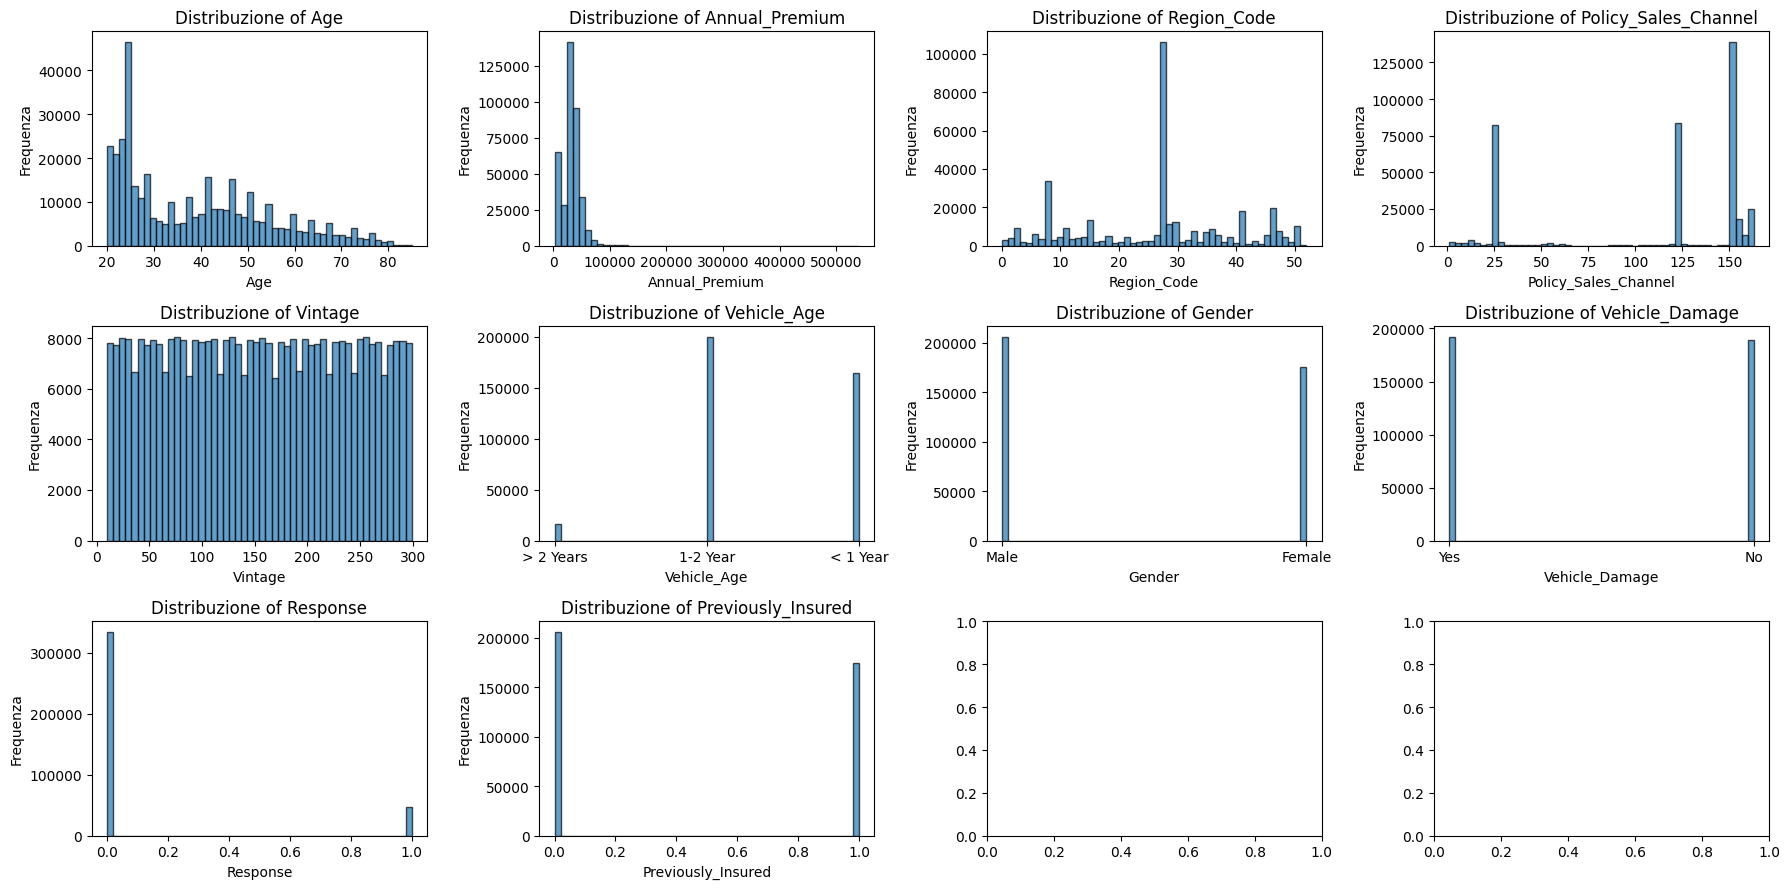

In [ ]:
features = ["Age", "Annual_Premium","Region_Code", "Policy_Sales_Channel", "Vintage","Vehicle_Age","Gender","Vehicle_Damage", "Response", "Previously_Insured"]
fig, axes = plt.subplots(3,4,  figsize=(18,9))
axes=axes.flatten()
for i,feature in enumerate(features):
  axes[i].hist(df[feature], bins=50, edgecolor="black", alpha=0.7)
  axes[i].set_title(f"Distribuzione of {feature}")
  axes[i].set_xlabel(feature)
  axes[i].set_ylabel("Frequenza")
plt.tight_layout()
plt.show()

Notiamo che le distribuzioni delle features sono molto diverse fra loro, e nello specifico per alcune variabili le categorie sono molto ridotte, persino binarie come nel caso di Gender, Vehicle_Damage,Previously_Insured, mentre per la variabile Vehicle_Age la features presenta solo 3 modalità che identificano l'anzianità dell'auuto. Discorso diverso si fa per le variabili categoriche cardinali come Region_Code, Policy_Sales_Channel dove le variabili mostrano categorie ad alta cardinalità con molti livelli poco frequenti. Vintage invece presenta una distribuzione dei valori numerici di anzianità clientelare del cliente molto uniforme in termini di frequenza. La variabile Annual Premium invece presenta una distribuzione numerica con una forte asimmetria positiva con molti valori frequenti per i valori distributivi inferiori e pochi ad ad premi annuali. Infine, visivamente la features Age mostra la distribuzione che più approssima una distribuzione normale, con una componente di asimmetria positiva.

Di seguito analizziamo i valori unici all'interno delle features del dataset con il metodo **nunique()** di Pandas:

In [ ]:
df.nunique()

,0
Gender,2
Age,66
Driving_License,2
Region_Code,53
Previously_Insured,2
Vehicle_Age,3
Vehicle_Damage,2
Annual_Premium,48838
Policy_Sales_Channel,155
Vintage,290


Capiamo invece con la con quale logica sono stratificati i livelli unici delle varie features, con il metodo **.unique()** della libreria di Pandas

In [ ]:
#analisi stratificazioni livelli delle classi
for column in ["Annual_Premium","Vintage","Vintage"]:
  print(f"Feature {column} :  {df[column].unique()[:10]} " )
for column in ["Driving_License",
               "Previously_Insured",
               "Vehicle_Age",
               "Vehicle_Damage",
               "Annual_Premium",
               "Gender"]:
               print(f"Feature {column} :  {df[column].unique() }" )


Feature Annual_Premium :  [40454. 33536. 38294. 28619. 27496.  2630. 23367. 32031. 27619. 28771.] 
Feature Vintage :  [217 183  27 203  39 176 249  72  28  80] 
Feature Vintage :  [217 183  27 203  39 176 249  72  28  80] 
Feature Driving_License :  [1 0]
Feature Previously_Insured :  [0 1]
Feature Vehicle_Age :  ['> 2 Years' '1-2 Year' '< 1 Year']
Feature Vehicle_Damage :  ['Yes' 'No']
Feature Annual_Premium :  [ 40454.  33536.  38294. ...  20706. 101664.  69845.]
Feature Gender :  ['Male' 'Female']


Nelle sezioni successive passere alle codifiche delle variabili qualitative discrete tramite *label encoding e ordinal encoding*, mentre per le features con distribuzioni numeriche discrete ad alta cardinalità verranno effettuati preprocessing di frequency encoding per accorpare le classi meno frequenti e ridurre la dimensionalità del dataset per i futuri modelli di machine learning. Inotre, verranno effettuate dove necessario anche operazioni di standardizzazione dei dati tramite libredi di scikit-learn.

# **4. PREPROCESSING DATA**

## **4.1 - Encoding**

Con il seguente blocco di codice, creiamo una copia del dataset originale in un nuovo oggetto dataframe **dfmap**, ed eseguiamo un ordinal encoding per la variabile Age, e un label encoding per la variabile Gender e Vehicle_damage:

In [ ]:
#data econding
dfmap = df.copy()
size_map_V_Age = { "> 2 Years":3,
                  "1-2 Year":2,
                   "< 1 Year":1}
size_map_Gender = { "Male":1,
                  "Female":0}
size_map_V_damage = { "Yes":1,
                  "No":0}
dfmap["Vehicle_Age"] = dfmap["Vehicle_Age"].map(size_map_V_Age)
dfmap["Gender"] = dfmap["Gender"].map(size_map_Gender)
dfmap["Vehicle_Damage"] = dfmap["Vehicle_Damage"].map(size_map_V_damage)
dfmap.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,1,44,1,28.0,0,3,1,40454.0,26.0,217,1
2,1,76,1,3.0,0,2,0,33536.0,26.0,183,0
3,1,47,1,28.0,0,3,1,38294.0,26.0,27,1
4,1,21,1,11.0,1,1,0,28619.0,152.0,203,0
5,0,29,1,41.0,1,1,0,27496.0,152.0,39,0


verifichiamo le modifiche apportate con le relative modifiche di encoding:

In [ ]:
dfmap.info()
print("\n")
print("Conteggio valori unici nel nuovo dataset dfmap\n", dfmap.nunique())
print("\n")
for column in ["Annual_Premium","Vintage"]:
  print(f"Strafificazione livello di {column} :  {dfmap[column].unique()[:10]} ")
for column in ["Driving_License",
               "Previously_Insured",
               "Vehicle_Age",
               "Vehicle_Damage",
               "Annual_Premium",
               "Gender"]:
               print(f"Stratificazione livello di {column} :  {dfmap[column].unique() }" )

from collections import Counter
# Lista delle feature categoriche
features = ["Gender", "Driving_License", "Region_Code", "Previously_Insured",
            "Vehicle_Age", "Policy_Sales_Channel", "Response"]
print("\n")
def gini_index(data):
    total = len(data)
    freqs = Counter(data)
    gini = 1 - sum((count / total) ** 2 for count in freqs.values())
    return gini
gini_list = [gini_index(dfmap[feature]) for feature in features]
gini_feature_pairs = list(zip(features, gini_list))
gini_feature_pairs.sort(key=lambda x: x[1], reverse=True)  # Ordinato in ordine decrescente
gini_df = pd.DataFrame(gini_feature_pairs, columns=["Feature", "Gini Index"]).round(2)
gini_df

<class 'pandas.core.frame.DataFrame'>
Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 34.9 MB


Conteggio valori unici nel nuovo dataset dfmap
 Gender                      2
Age                        66
Driving_License             2
Region_Code                

,Feature,Gini Index
0,Region_Code,0.90
1,Policy_Sales_Channel,0.79
2,Vehicle_Age,0.54
3,Gender,0.50
4,Previously_Insured,0.50
5,Response,0.22
6,Driving_License,0.00


Si osserva che il nuovo dataset dfmap mantiene lo stesso numero di osservazioni uniche, ma questa volta tutte le variabili sono codificate numericamente e non hanno stringhe come caratteri di codifica, i quali potrebbero dare problemi ai modelli di machine learning.

## **4.2 Frequency Encoding**

Creiamo nuovamente un nuovo dataset copia del precedente dfmap, e il nuovo lo chiamiamo **dfencode**, in cui opererò alle features "Policy_Sales_Channel" e "Region_Code" una codifica di tipo  frequency encoding al fine accorpare le classi meno frequenti ( rispettivamente frequenza relativa < di 0.01 e 0.03)

In [ ]:
#  Policy_Sales_Channel
dfencode=dfmap.copy()
threshold = 0.01
freqs=dfencode["Policy_Sales_Channel"].value_counts(normalize=True)
dfencode["Policy_Sales_Channel"]=dfencode["Policy_Sales_Channel"].apply(lambda x:
                                                                        x if freqs[x] >= threshold else -1)
print("n. di valori unici: ", dfencode["Policy_Sales_Channel"].nunique(),
      "\nvalori:\n",dfencode["Policy_Sales_Channel"].unique())
#Feature REGION CODE
threshold2 = 0.03
freqs2=dfencode["Region_Code"].value_counts(normalize=True)
dfencode["Region_Code"]=dfencode["Region_Code"].apply(lambda x:
                                                      x if freqs2[x] >= threshold2 else -1)

dfencode.info()
print("\nConteggio valori unici nel nuovo dataset dfmap\n", dfencode.nunique())
print("\n")
for column in ["Annual_Premium","Vintage", "Policy_Sales_Channel", "Region_Code"]:
  print(f"Strafificazione livello di {column} :  {dfencode[column].unique()[:10]} " )
for column in ["Driving_License",
               "Previously_Insured",
               "Vehicle_Age",
               "Vehicle_Damage",
               "Annual_Premium",
               "Gender"]:
               print(f"Stratificazione livello di {column} :  {dfencode[column].unique() }" )

n. di valori unici:  10 
valori:
 [ 26. 152. 160. 124.  -1. 156. 157. 122. 154. 151.]
<class 'pandas.core.frame.DataFrame'>
Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 34.9 MB

Conteggio valori unici nel nuovo dataset dfmap
 Gender                      2
Ag

In [ ]:
dfencode.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,1,44,1,28.0,0,3,1,40454.0,26.0,217,1
2,1,76,1,-1.0,0,2,0,33536.0,26.0,183,0
3,1,47,1,28.0,0,3,1,38294.0,26.0,27,1
4,1,21,1,-1.0,1,1,0,28619.0,152.0,203,0
5,0,29,1,41.0,1,1,0,27496.0,152.0,39,0


## **4.3 - EDA UNIVARIATA (VARIABILI NUMERICHE)**

A questo punto tutte le variabli del dataset sono state opportunamente codificate e possiamo passare all'analisi esplorativa univariata degli indici di posizione, e variabilità di tutte le features numeriche continue:

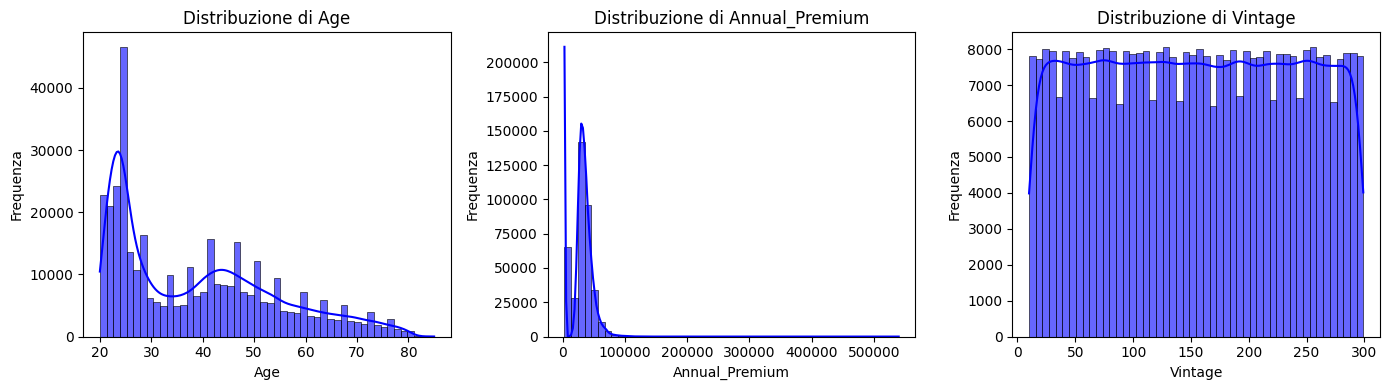

In [ ]:
numerical_vars = ["Age", "Annual_Premium", "Vintage"]
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes = axes.flatten()
for i, feature in enumerate(numerical_vars):
    sns.histplot(dfencode[feature],
                 bins=50, kde=True,
                 ax=axes[i],
                 color="blue", edgecolor="black", alpha=0.6)
    axes[i].set_title(f"Distribuzione di {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequenza")
plt.tight_layout()
plt.show()

skewtest di Age --> SkewtestResult(statistic=154.55628102033262, pvalue=0.0)
Distribuzione NON SIMMETRICA
Age ---> ShapiroResult(statistic=0.91017768500043, pvalue=5.329840656194579e-136)
NON NORMALE
p-value Kolmogorov-Smirnov : 0.0
NON NORMALE SECONDO Kolmogorov-Smirnov


skewtest di Annual_Premium --> SkewtestResult(statistic=311.61051141442067, pvalue=0.0)
Distribuzione NON SIMMETRICA
Annual_Premium ---> ShapiroResult(statistic=0.8733076293840272, pvalue=1.0038435350297132e-146)
NON NORMALE
p-value Kolmogorov-Smirnov : 0.0
NON NORMALE SECONDO Kolmogorov-Smirnov


skewtest di Vintage --> SkewtestResult(statistic=0.7635336745811601, pvalue=0.44514518738055864)
Distribuzione SIMMETRICA

Vintage ---> ShapiroResult(statistic=0.9548895377997788, pvalue=9.200100034124278e-116)
NON NORMALE
p-value Kolmogorov-Smirnov : 0.0
NON NORMALE SECONDO Kolmogorov-Smirnov




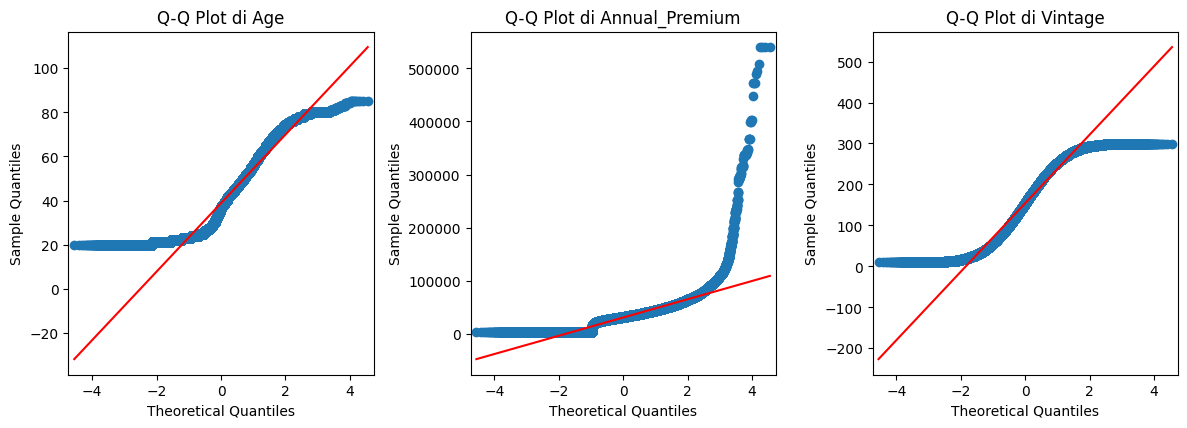

,Age,Annual_Premium,Vintage
count,381109.00,381109.00,381109.00
mean,38.82,30564.39,154.35
std,15.51,17213.16,83.67
min,20.00,2630.00,10.00
25%,25.00,24405.00,82.00
50%,36.00,31669.00,154.00
75%,49.00,39400.00,227.00
max,85.00,540165.00,299.00


In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, message=".*shapiro.*")
numerical_vars = ["Age", "Annual_Premium", "Vintage"]
rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
axes = axes.flatten()
for idx, var in enumerate(numerical_vars):
    ax = axes[idx]
    # Q-Q Plot
    sm.qqplot(dfencode[var], line="s", ax=ax)
    ax.set_title(f"Q-Q Plot di {var}")
    skew_test = skewtest(dfencode[var])
    print(f"skewtest di {var} --> {skew_test}")
    if skew_test.pvalue > 0.05:
        print("Distribuzione SIMMETRICA\n")
    else:
        print("Distribuzione NON SIMMETRICA")
    # Test di normalità di Shapiro-Wilk
    shapiro_test = shapiro(dfencode[var])
    print(f"{var} ---> {shapiro_test}")
    if shapiro_test.pvalue > 0.05:
        print("NORMALE")
    else:
        print("NON NORMALE")
    # Test di Kolmogorov-Smirnov
    stat, p_value = kstest(dfencode[var], 'norm')
    print(f"p-value Kolmogorov-Smirnov : {p_value}")
    if p_value > 0.05:
        print("NORMALE SECONDO Kolmogorov-Smirnov\n\n")
    else:
        print("NON NORMALE SECONDO Kolmogorov-Smirnov\n\n")
# Nasconde eventuali assi vuoti se ci sono meno di 16 grafici
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()
#indici di posizione e variabilità
dfencode[numerical_vars].describe().round(2)

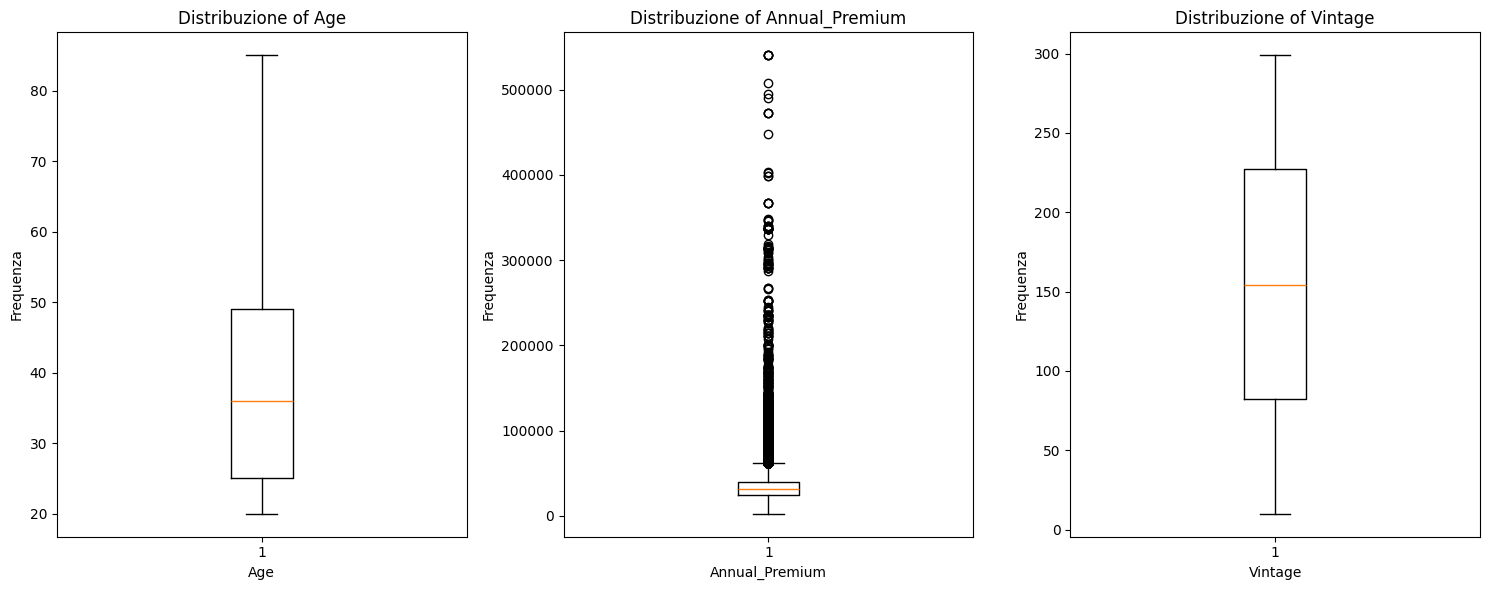

In [ ]:
#boxplot delle distribuzioni numeriche continue
fig, axes = plt.subplots(1,3,  figsize=(15,6))
axes=axes.flatten()
for i, feature in enumerate(numerical_vars):
        axes[i].boxplot(dfencode[feature])
        axes[i].set_title(f"Distribuzione of {feature}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequenza")
plt.tight_layout()
plt.show()

tutte le variabili numeriche presentano range numerici molto ampi ed, in particolare, che dal boxplot della distribuzione numerica della  features Annual_Premium_ siano presenti  molti outliers. <br>Nello specifico, abbiamo che:

- **Age**: la clientela ha una media d'età sui 38.82 anni e mediana di 36anni, indicando una campione di statistica del dataset  che include le fasce d'eta più giovani, adulte ed anziane;
- **Annual_Premium**: il range del premio assicurativo annuale pagato dai clienti va da un min di 2630€ a 540165€, una media di 30564.39€ e mediana di 31669€,  e una dev. standard di 17213€. La presenza  indicando un'alta variabilità nel dataset e la presenza alti valori di premi annuali indica la presenza di un'asimmetria della positiva della curva di distribuzione

- **Vintage**: non ci sono ragioni per rifiutare l'ipotesi nulla di simmetria HO della distribuzione (pvalue: 0.45), ma non è distribuita normalmente. Quindi il vettore dati per questa features è abbastanza omogeneo nelle sue modalità. Presenta una media e mediana di 154 mesi eun range di 281

## **4.4 - EDA UNIVARIATA (VARIABILI CATEGORICHE)**

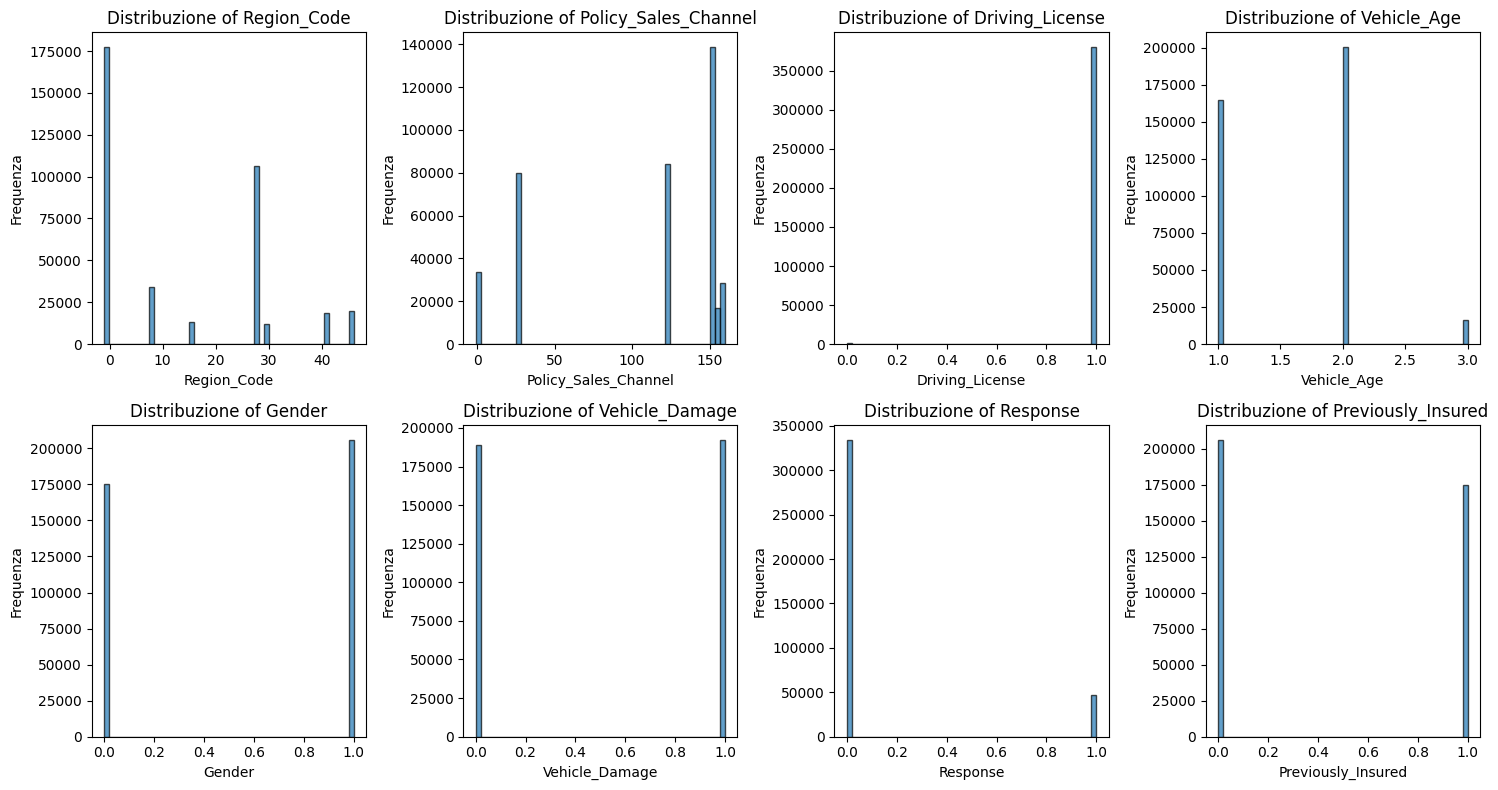

In [ ]:
features = ["Region_Code", "Policy_Sales_Channel","Driving_License",
            "Vehicle_Age","Gender","Vehicle_Damage", "Response", "Previously_Insured"]
fig, axes = plt.subplots(2,4,  figsize=(15,8))
axes=axes.flatten()
for i,feature in enumerate(features):
  axes[i].hist(dfencode[feature], bins=50, edgecolor="black", alpha=0.7)
  axes[i].set_title(f"Distribuzione of {feature}")
  axes[i].set_xlabel(feature)
  axes[i].set_ylabel("Frequenza")
plt.tight_layout()
plt.show()

**DISTRIBUZIONE DI FREQUENZA RELATIVA % DELLE FEATURES**

In [ ]:
for column in ["Gender", "Driving_License","Region_Code", "Previously_Insured", "Vehicle_Age", "Policy_Sales_Channel"]:
    print(f"Distribuzione di frequenza relative % di {str(column).upper()}:\n{dfencode[column].value_counts(normalize=True).round(3)*100}\n")

Distribuzione di frequenza relative % di GENDER:
Gender
1    54.1
0    45.9
Name: proportion, dtype: float64

Distribuzione di frequenza relative % di DRIVING_LICENSE:
Driving_License
1    99.8
0     0.2
Name: proportion, dtype: float64

Distribuzione di frequenza relative % di REGION_CODE:
Region_Code
-1.0     46.5
 28.0    27.9
 8.0      8.9
 46.0     5.2
 41.0     4.8
 15.0     3.5
 30.0     3.2
Name: proportion, dtype: float64

Distribuzione di frequenza relative % di PREVIOUSLY_INSURED:
Previously_Insured
0    54.2
1    45.8
Name: proportion, dtype: float64

Distribuzione di frequenza relative % di VEHICLE_AGE:
Vehicle_Age
2    52.6
1    43.2
3     4.2
Name: proportion, dtype: float64

Distribuzione di frequenza relative % di POLICY_SALES_CHANNEL:
Policy_Sales_Channel
 152.0    35.4
 26.0     20.9
 124.0    19.4
-1.0       8.8
 160.0     5.7
 156.0     2.8
 122.0     2.6
 157.0     1.8
 154.0     1.6
 151.0     1.0
Name: proportion, dtype: float64



**DISTRIBUZIONE DI FREQUENZA DELLA RISPOSTA** *("RESPONSE")*

In [ ]:
print("FREQUENZE ASSOLUTE VARIABILE RISPOSTA\n")
print(dfencode["Response"].value_counts())
print("FREQUENZE RELATIVE VARIABILE RISPOSTA")
print(dfencode["Response"].value_counts(normalize=True).round(2))

FREQUENZE ASSOLUTE VARIABILE RISPOSTA

Response
0    334399
1     46710
Name: count, dtype: int64
FREQUENZE RELATIVE VARIABILE RISPOSTA
Response
0    0.88
1    0.12
Name: proportion, dtype: float64


**INDICE DI ETEROGENEITA' DI GINI**
- Gini = 0 (massima concentrazione)
- Gini = 1 (massima eterogeneità)

In [ ]:
features = ["Gender", "Driving_License", "Region_Code", "Previously_Insured",
            "Vehicle_Age", "Policy_Sales_Channel", "Response"]
def gini_index(data):
    total = len(data)
    freqs = Counter(data)
    gini = 1 - sum((count / total) ** 2 for count in freqs.values())
    return gini
gini_list = [gini_index(dfencode[feature]) for feature in features]
gini_feature_pairs = list(zip(features, gini_list))
gini_feature_pairs.sort(key=lambda x: x[1], reverse=True)  # Ordinato in ordine decrescente
gini_df = pd.DataFrame(gini_feature_pairs, columns=["Feature", "Gini Index"]).round(2)
gini_df

,Feature,Gini Index
0,Policy_Sales_Channel,0.78
1,Region_Code,0.69
2,Vehicle_Age,0.54
3,Gender,0.50
4,Previously_Insured,0.50
5,Response,0.22
6,Driving_License,0.00


Incrociando i dati delle distribuzione delle frequenze con i dati ottenuti dal calcolo dell'indice di eterogeneità di Gini otteniamo che:

- **Policy_Sales_Channel**: l'assicurazione presenta molti canali di vendita, e molti canali che presentano una bassissima frequenza sono stati accorpati nel canali di vendita -1. I canali di vendita più registrati di frequenti nel dataset sono 152.0, 26.0 e il 124.0, con più del 75% raggruppato delle frequenze relative raggruppate;

- **Region_code**: variabile categorica cardinale (con tante categorie), presenta un indice di Gini discretamente alto (0.69) indicando come per la variabile precedente una buona eterogeneità delle regioni di provenienza dei clienti. La moda della features è 28 con il 27.9% della frequenza relativa all'interno dei livelli di stratificazione di questa features;

- **Gender**: variabile dicotomica (female=0 e male=1), quasi equamente distribuita fra i 2 sessi a favore del sesso maschile.

- **Driving_Licence**: variabile dicotomica 0 (no patente) e 1 (si patente), con media e mediana centrate praticamente su 1 indicando che la maggior parte dei clienti intervistati possedevano una patente.

- **Previosly_Insured**: variabile categorica 0(precendete NON assicurato) e 1 (precedente assicurato), la feature ha una distribuzione a favore dei casi dei clienti precedentemente NON assicurati del 54.2% di frequenza relativa, mentre il 45.8% era precedente assicurato al momento della registrazione dell'osservazione.

- **Response (variabile target)**: Si osserva infatti che l'**88% delle osservazioni del dataset (334399 osservazioni)** sono relative alla categoria response 0, mentre il restante **12% (46710 osservazioni)** sono relative alla categoria response 1.

E' importante tenere a mente che esiste uno sbilanciamento fra l'occorrenza delle risposte 0 (NO cross selling assicurativo) e le risposte 1 (Si cross-selling) fra le varie osservazione di clienti. Questo sbilanciamento può creare problemi predittivi ai modelli previsionali di regressione logistica che potrebbero essere utilizzati per prevedere il comportamente di nuovi clienti al cross selling futuro.

# 5. **ANALISI ESPLORATIVA EDA - MULTIVARIATA**

Iniziamo con il plottare gli scatterplot bidimensionali delle variabili di interesse, al fine di ricercare correlazioni visive fra le features di "maggior interesse" per lo studio.

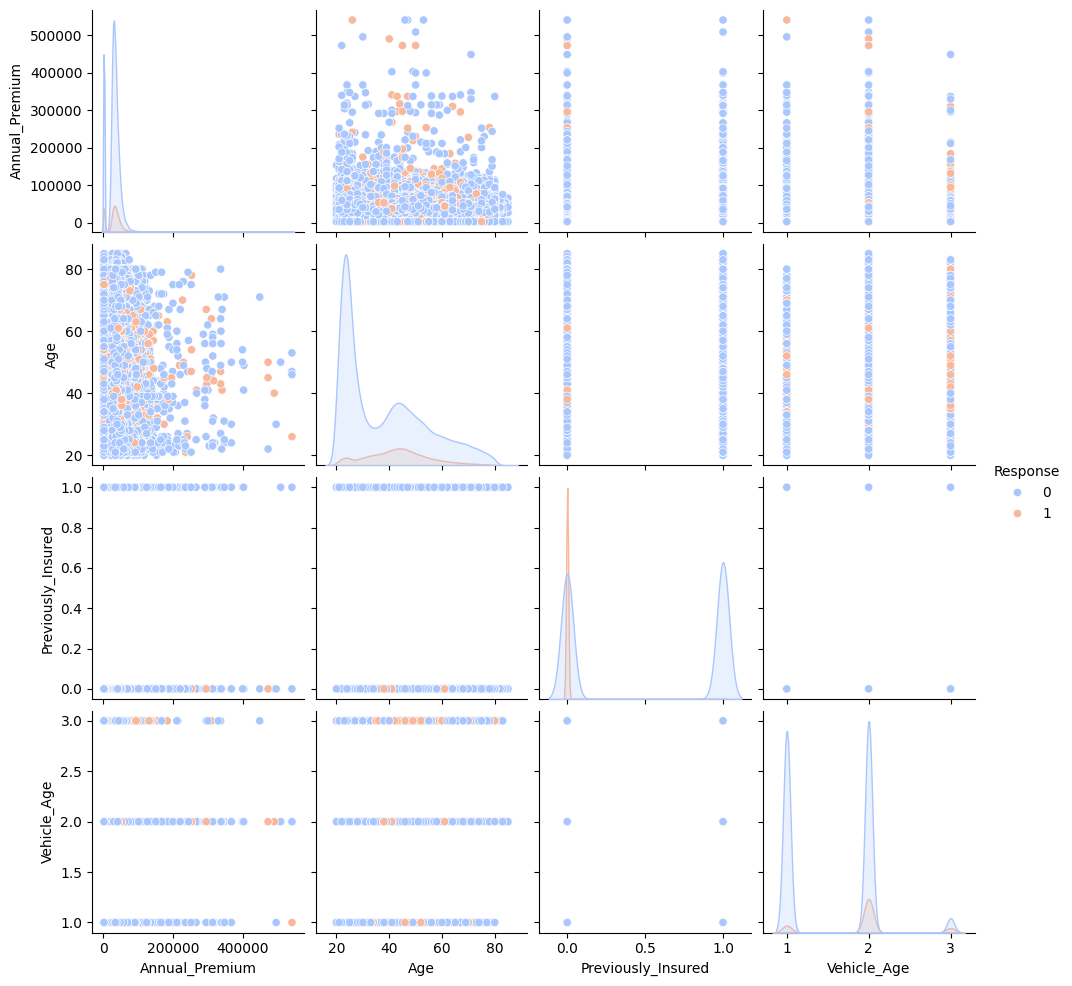

In [ ]:
lista = ["Annual_Premium", "Age", "Previously_Insured", "Vehicle_Age", "Response"]
sns.pairplot(dfencode[lista],
             hue="Response",
             diag_kind="kde",
             palette="coolwarm")
plt.show()

dagli scatterplot bivariati non è possibile risalire visivamente ad alcuna correlazione. Passiamo nella prossima sezione all'analisi numerica, tramite matrici di correlazione bivariate fra le variabili del dataset opportunamente processato

# 6 . **LA MATRICE DI CORRELAZIONE**

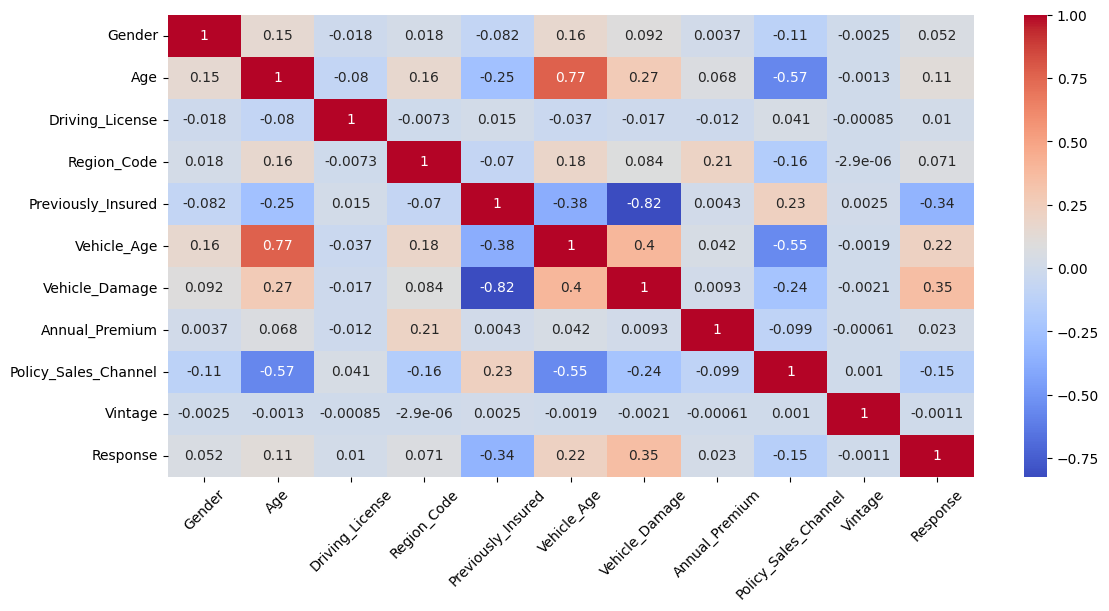

In [ ]:
#Le relazioni tra variabili chiave come Annual Premium, Vehicle Age, Previously Insured, e la risposta del cliente.
plt.figure(figsize=(13,6))
sns.heatmap(dfencode.corr(method='pearson'),  #<- di default la matrice di correlazione è di Pearson
            annot=True,
            cmap="coolwarm") #<- numerazione sulla casella
plt.xticks(rotation=45, fontsize=10)
plt.show()

- **correlazione negativa (-0.82) fra previosly_insured e Vehicle_damage** indicando come clienti precedentemente più assicurati probabilmente sono più prudenti o vengono premiati per politica assicurativa ad avere comportamenti virtusosi

- sembra esserci una **correlazione positiva fra Age e Vehicle Age (0.77)**, ha senso basti pensare che persone più anziane possiedono da più tempo una macchina
- correlazione negativa **(-0.58) fra Age e Policy_sales_Channel** indicando come con l'aumentare dell'età cambino anche le modalità di utilizzo dei sistemi informativi da parte delle persone

- **correlazione negativa (-0.55) fra Vehicle_age e Policy_sales_channel** ed è probabile che macchine più vecchie possedute da clienti più anziani utilizzino determinati sistemi informativi, piuttosto che altri. In questo caso la variabile nascosta è l'eta del cliente e non può sussistere causa-effetto fra l'eta del veicolo e la policy_sales_channe;

- **correlazione positiva (+0.4) fra Vehicle_age e Vehicle_damage** probabilmente legata la fatto che veicoli con uno storico maggiore abbiano avuto maggiore probabilità di incorrere in un incidente in passato

- **correlazione negativa (-0.38) fra Previosly_Insured e Vehicle_Age**
- **correlazione positiva (+0.27) fra Age e Vehicle_Damage** perchè si è visto esserci uno storico di clienti più anziani con veicoli più anziani. Quindi la varibile nascosta qui è il veicolo pià vecchio possuduti da clienti più anziani
- **correlazione negativa (-0.25) fra Previosly_Insured e Age** sembrebbe che clienti più anziani abbiano avuto meno possibilità di stipulare in passato un'assicurazione. E' lecito credere che NON sussista causa-effetto
  

Dagli scatterplots intuitivamente non è possibile visualizzare una chiara relazione fra le variabili. Passeremo quindi alle visualizzazioni delle distribuzioni numeriche condizionate alla variabille risposta, visualizzando i risultati tramite boxplots affiancati


# 7 .  **ANNUAL PREMIUM VS RESPONSE**

Correlazione Point-Biserial:  0.0226
P-value:  3.722315141424481e-44

T-test - DIFFERENZA STATISTICA FRA LE MEDIE FRA I GRUPPI DI RISPOSTA

T-test:  -13.9398
P-value:  3.7223151414267487e-44

Matrice di Confusione OVER SAMPLING DELLA CLASSE MINORITARIA (0):
 [[48204 52124]
 [43060 57252]]

Report di classificazione OVER SAMPLING DELLA CLASSE MINORITARIA (0):
               precision    recall  f1-score   support

           0       0.53      0.48      0.50    100328
           1       0.52      0.57      0.55    100312

    accuracy                           0.53    200640
   macro avg       0.53      0.53      0.52    200640
weighted avg       0.53      0.53      0.52    200640


RISULTATI MODELLO LOGISTICO

Coefficients: [[-6.16371810e-02  3.97411969e-06]]
Intercept: [-0.06163718]

ESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA
[0.94022396 0.94022396 1.00000397]

Matrice di Confusione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):
 [[7037 6944]
 [6376 7669]]

Report di 

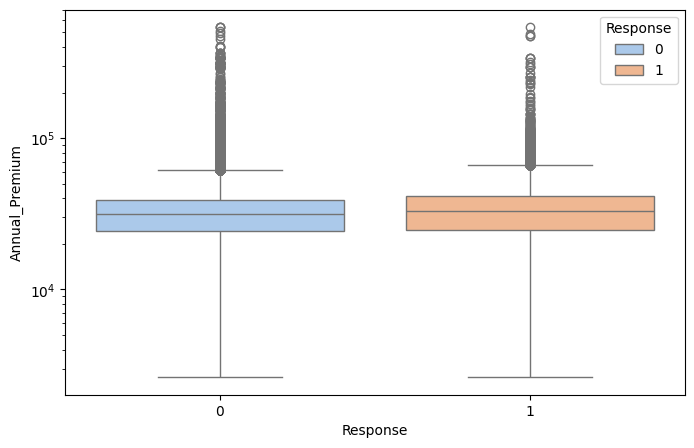

In [ ]:
#relazione Annual Premium vs Response (Numerica vs Dicotomica)
#correlazione point-biseriale
correlation, p_value = pointbiserialr(dfencode["Annual_Premium"], dfencode["Response"])
print("Correlazione Point-Biserial: ", round(correlation,4))
print("P-value: ", p_value)

#t-test
print("\nT-test - DIFFERENZA STATISTICA FRA LE MEDIE FRA I GRUPPI DI RISPOSTA\n")
gruppo_0 = dfencode['Annual_Premium'][dfencode['Response'] == 0]
gruppo_1 = dfencode['Annual_Premium'][dfencode['Response'] == 1]
t_test, p_value = ttest_ind(gruppo_0, gruppo_1)
print("T-test: ", round(t_test,4))
print("P-value: ", p_value)

#Regressione logistica
#RANDOM SAMPLE OVER SAMPLING DELLA CLASSE MINORITARIA (RESPONSE = 0)
X = dfencode[["Annual_Premium"]]
X = sm.add_constant(X)  # aggiungo l'intercetta
y = dfencode["Response"]
ros = RandomOverSampler(random_state=RANDOM_SEED)
X_resampled, y_resampled = ros.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nMatrice di Confusione OVER SAMPLING DELLA CLASSE MINORITARIA (0):\n", confusion_matrix(y_test, y_pred))
print("\nReport di classificazione OVER SAMPLING DELLA CLASSE MINORITARIA (0):\n", classification_report(y_test, y_pred))
#risultati regressione logistica
print("\nRISULTATI MODELLO LOGISTICO\n")
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("\nESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA")
odds_ratios = np.exp(np.concatenate([model.intercept_, model.coef_[0]]))
print(odds_ratios)

#RANDOM UNDER  SAMPLING DELLA CLASSE MAGGIORITARIA (RESPONSE =1)
X = dfencode[["Annual_Premium"]]
X = sm.add_constant(X)  # aggiungo l'intercetta
y = dfencode["Response"]
rus = RandomUnderSampler(random_state=RANDOM_SEED)
X_resampled, y_resampled = rus.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nMatrice di Confusione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):\n", confusion_matrix(y_test, y_pred))
print("\nReport di classificazione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):\n", classification_report(y_test, y_pred))
#risultati regressione logistica
print("\nRISULTATI MODELLO LOGISTICO\n")
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("\nESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA")
odds_ratios = np.exp(np.concatenate([model.intercept_, model.coef_[0]]))
print(odds_ratios)

#BOXPLOTS CONDIZIONATI
plt.figure(figsize=(8,5))
sns.boxplot(data=dfencode,
            x="Response",
            y="Annual_Premium",
            hue="Response",
            palette="pastel")
plt.yscale("log")
plt.show()

esiste una correlazione pressochè nulla fra le variabili Annual Preium e la risposta. Il t-test indica una differenza significativa statistica, ma il modello di regressione logistica indica che la prababilità di avere cross-selling abbia un fattore moltiplicativo di 1 per ogni aumento unitario annual premium, indicando di fatto quasi una decorrelazione e un effetto ininfluente di Annual premium su Response

analisi dei barplot delle variabili categoriche condizionate alla risposta target di cross-selling assicurativo:

Si osserva visivamente che:
- i casi di risposta positiva al cross-selling aumentano se il veicolo in passato ha subito danni
- i casi di risposta positiva al cross-selling sembri aumentare all'aumentare dell'anzianità del veicolo, con un massimo d'eta compresa fra 1 e 2 anni

# 8 . **VEHICLE AGE VS RESPONSE**

In [ ]:
#test del chi-quadrato
contingency_table = pd.crosstab(dfencode["Vehicle_Age"], dfencode["Response"])
print("TABELLA DI CONTIGENZA\n",contingency_table)
print("\nTEST DEL CHI-QUADRATO")
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("\nChi-quadrato:", chi2)
print("P-value:", p)
print("Gradi di libertà:", dof)
print("Attesa:\n", expected)

# Calcoliamo il V di Cramer
def cramers_v(cont_table):
    chi2 = chi2_contingency(cont_table)[0]
    n = np.sum(cont_table.values)
    k = min(cont_table.shape)-1
    return np.sqrt(chi2 / (n * k))
v_cramer = cramers_v(contingency_table)
print("\nRISULTATI V DI CRAMER")
print("V di Cramer:", v_cramer)

#regressione logistica
# Definizione delle variabili indipendenti e dipendenti
X = dfencode[["Vehicle_Age"]]
X = sm.add_constant(X)  # aggiungo l'intercetta
y = dfencode["Response"]
model_balanced = LogisticRegression(class_weight='balanced')
model_balanced.fit(X, y)
y_pred_balanced = model_balanced.predict(X)
conf_matrix_balanced = confusion_matrix(y, y_pred_balanced)
print("\nMATRICE DI CONFUSIONE DEL MODELLO:\n", conf_matrix_balanced)
print(classification_report(y, y_pred_balanced))
print("\nRISULTATI MODELLO LOGISTICO\n")
print("Coefficients:", model_balanced.coef_)
print("Intercept:", model_balanced.intercept_)
print("\nESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA")
odds_ratios = np.exp(np.concatenate([model_balanced.intercept_, model_balanced.coef_[0]]))
print(odds_ratios)

TABELLA DI CONTIGENZA
 Response          0      1
Vehicle_Age               
1            157584   7202
2            165510  34806
3             11305   4702

TEST DEL CHI-QUADRATO

Chi-quadrato: 18771.889904151052
P-value: 0.0
Gradi di libertà: 2
Attesa:
 [[144589.27397149  20196.72602851]
 [175764.59775025  24551.40224975]
 [ 14045.12827826   1961.87172174]]

RISULTATI V DI CRAMER
V di Cramer: 0.22193683930699235

MATRICE DI CONFUSIONE DEL MODELLO:
 [[157584 176815]
 [  7202  39508]]
              precision    recall  f1-score   support

           0       0.96      0.47      0.63    334399
           1       0.18      0.85      0.30     46710

    accuracy                           0.52    381109
   macro avg       0.57      0.66      0.47    381109
weighted avg       0.86      0.52      0.59    381109


RISULTATI MODELLO LOGISTICO

Coefficients: [[-1.17543074  1.3385256 ]]
Intercept: [-1.17556693]

ESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA
[0.30864395 0.30868599 

In [ ]:
#smote (SMOTE (Synthetic Minority Over-sampling Technique)
X = dfencode[["Vehicle_Age"]]
X = sm.add_constant(X)  # aggiungo l'intercetta
y = dfencode["Response"]
smote=SMOTE(sampling_strategy="auto", random_state=RANDOM_SEED)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nMatrice di Confusione SMOTE:\n", confusion_matrix(y_test, y_pred))
print("\nReport di classificazione SMOTE:\n", classification_report(y_test, y_pred))
#risultati regressione logistica
print("\nRISULTATI MODELLO LOGISTICO\n")
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("\nESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA")
odds_ratios = np.exp(np.concatenate([model.intercept_, model.coef_[0]]))
print(odds_ratios)


Matrice di Confusione SMOTE:
 [[47171 53157]
 [15644 84668]]

Report di classificazione SMOTE:
               precision    recall  f1-score   support

           0       0.75      0.47      0.58    100328
           1       0.61      0.84      0.71    100312

    accuracy                           0.66    200640
   macro avg       0.68      0.66      0.64    200640
weighted avg       0.68      0.66      0.64    200640


RISULTATI MODELLO LOGISTICO

Coefficients: [[-1.17914972  1.34299111]]
Intercept: [-1.17926189]

ESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA
[0.30750563 0.30754012 3.83048379]


In [ ]:
#RANDOM SAMPLE OVER SAMPLING DELLA CLASSE MINORITARIA (RESPONSE = 0)
X = dfencode[["Vehicle_Age"]]
X = sm.add_constant(X)  # aggiungo l'intercetta
y = dfencode["Response"]
ros = RandomOverSampler(random_state=RANDOM_SEED)
X_resampled, y_resampled = ros.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nMatrice di Confusione OVER SAMPLING DELLA CLASSE MINORITARIA (0):\n", confusion_matrix(y_test, y_pred))
print("\nReport di classificazione OVER SAMPLING DELLA CLASSE MINORITARIA (0):\n", classification_report(y_test, y_pred))
#risultati regressione logistica
print("\nRISULTATI MODELLO LOGISTICO\n")
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("\nESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA")
odds_ratios = np.exp(np.concatenate([model.intercept_, model.coef_[0]]))
print(odds_ratios)


Matrice di Confusione OVER SAMPLING DELLA CLASSE MINORITARIA (0):
 [[47171 53157]
 [15484 84828]]

Report di classificazione OVER SAMPLING DELLA CLASSE MINORITARIA (0):
               precision    recall  f1-score   support

           0       0.75      0.47      0.58    100328
           1       0.61      0.85      0.71    100312

    accuracy                           0.66    200640
   macro avg       0.68      0.66      0.65    200640
weighted avg       0.68      0.66      0.65    200640


RISULTATI MODELLO LOGISTICO

Coefficients: [[-1.18707966  1.35163084]]
Intercept: [-1.18719271]

ESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA
[0.3050765  0.30511099 3.86372151]


In [ ]:
#RANDOM UNDER  SAMPLING DELLA CLASSE MAGGIORITARIA (RESPONSE =1)
X = dfencode[["Vehicle_Age"]]
X = sm.add_constant(X)  # aggiungo l'intercetta
y = dfencode["Response"]
rus = RandomUnderSampler(random_state=RANDOM_SEED)
X_resampled, y_resampled = rus.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nMatrice di Confusione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):\n", confusion_matrix(y_test, y_pred))
print("\nReport di classificazione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):\n", classification_report(y_test, y_pred))
#risultati regressione logistica
print("\nRISULTATI MODELLO LOGISTICO\n")
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("\nESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA")
odds_ratios = np.exp(np.concatenate([model.intercept_, model.coef_[0]]))
print(odds_ratios)


Matrice di Confusione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):
 [[ 6617  7364]
 [ 2208 11837]]

Report di classificazione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):
               precision    recall  f1-score   support

           0       0.75      0.47      0.58     13981
           1       0.62      0.84      0.71     14045

    accuracy                           0.66     28026
   macro avg       0.68      0.66      0.65     28026
weighted avg       0.68      0.66      0.65     28026


RISULTATI MODELLO LOGISTICO

Coefficients: [[-1.1677156  1.3268211]]
Intercept: [-1.16851736]

ESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA
[0.31082745 0.31107675 3.76904292]


In [ ]:
#APPROCCIO SMOTETomek (OVERSAMPLING (1) + UNDERSAMPLING (0))
X = dfencode[["Vehicle_Age"]]
X = sm.add_constant(X)  # aggiungo l'intercetta
y = dfencode["Response"]
smote_tomek = SMOTETomek(random_state=RANDOM_SEED)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nMatrice di Confusione SMOTETomek:\n", confusion_matrix(y_test, y_pred))
print("\nReport di classificazione SMOTETomek:\n", classification_report(y_test, y_pred))
#risultati regressione logistica
print("\nRISULTATI MODELLO LOGISTICO\n")
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("\nESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA")
odds_ratios = np.exp(np.concatenate([model.intercept_, model.coef_[0]]))
print(odds_ratios)


Matrice di Confusione SMOTETomek:
 [[4680 5206]
 [1526 8226]]

Report di classificazione SMOTETomek:
               precision    recall  f1-score   support

           0       0.75      0.47      0.58      9886
           1       0.61      0.84      0.71      9752

    accuracy                           0.66     19638
   macro avg       0.68      0.66      0.65     19638
weighted avg       0.68      0.66      0.65     19638


RISULTATI MODELLO LOGISTICO

Coefficients: [[-1.16756646  1.32920779]]
Intercept: [-1.16857134]

ESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA
[0.31081067 0.31112315 3.77804919]


Considerazioni ulteriori sull'età dei clienti, anzianità dei veicoli e storico incidenti, che vanno ad integrare le decisioni informate:

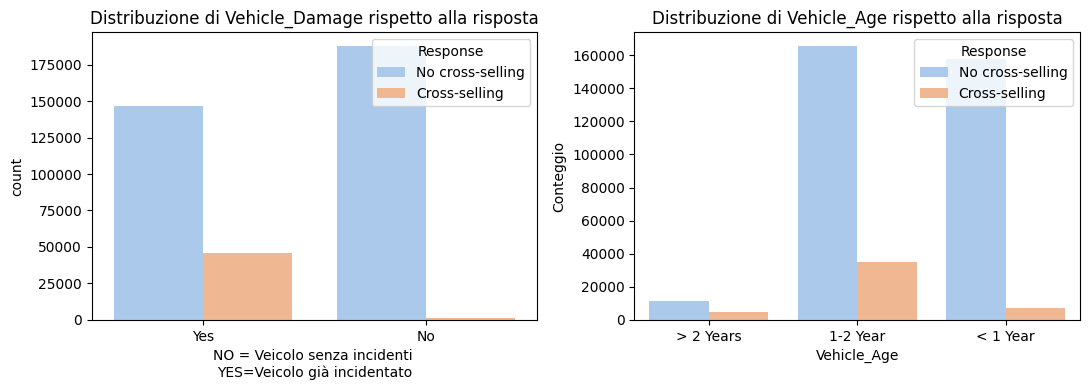

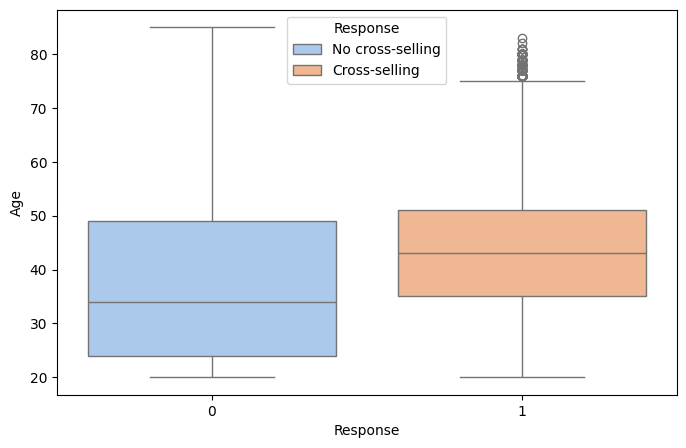


T-test - DIFFERENZA STATISTICA FRA LE LA MEDIA D'ETA FRA I GRUPPI DI RISPOSTA

T-test:  -69.0431
P-value:  0.0


,count,mean,std,min,25%,50%,75%,max
Response,,,,,,,,
0,334399.0,38.18,15.82,20.0,24.0,34.0,49.0,85.0
1,46710.0,43.44,12.17,20.0,35.0,43.0,51.0,83.0


In [ ]:
# Analisi della variabile Vehicle_Damage
features = ["Vehicle_Damage", "Vehicle_Age"]
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
hue_labels = {0: "No cross-selling", 1: "Cross-selling"}
for i, feature in enumerate(features):
    sns.countplot(x=feature, hue="Response", data=df, palette="pastel", ax=axes[i])
    handles, _ = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=handles,labels=[hue_labels[0], hue_labels[1]],title="Response")
    axes[i].set_title(f"Distribuzione di {feature} rispetto alla risposta")
    if feature == "Vehicle_Damage":
        axes[i].set_xlabel("NO = Veicolo senza incidenti \nYES=Veicolo già incidentato")
    else:
      axes[i].set_xlabel(feature)
      axes[i].set_ylabel("Conteggio")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=df,
            x="Response",
            y="Age",
            hue="Response",
            palette="pastel")
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
plt.legend(title="Response", labels=[hue_labels[0], hue_labels[1]])
plt.show()

print("\nT-test - DIFFERENZA STATISTICA FRA LE LA MEDIA D'ETA FRA I GRUPPI DI RISPOSTA\n")
gruppo_0 = dfencode['Age'][dfencode['Response'] == 0]
gruppo_1 = dfencode['Age'][dfencode['Response'] == 1]
t_test, p_value = ttest_ind(gruppo_0, gruppo_1)
print("T-test: ", round(t_test,4))
print("P-value: ", p_value)
summary=dfencode.groupby("Response")["Age"].describe().round(2)
summary

- Il test Chi-Quadro indica associazione fra Vehicle age e il cross sell (con un p value prossimo a 0). Inoltre sia la V di Cramer che il modello di regressione logistica indica una correlazione positiva fra la classe d'età del veicolo e il passaggio di classe da 0 -> 1. Parallelamente sono stati sviluppati i modelli di regressione logistica, fra Vehicle_Age e Response e si nota che dall'estrazione dei coefficienti dell'odds ratio, per ogni aumento di classe d'età del veicolo la probabilità che avvenga del cross selling in media aumenti di 3.8 volte circa.

- Dai grafici barpltos relativi Vehicle_Damage si può notare come lo storico di incidenti sul veicolo possa indurre al clienti ad eseguire cross-selling assicurativo, con una probabilità maggiore se il veicolo è stato incidentato in precedenza. Inoltre dai barplots di Vehicle_age in funzione della risposta si osserva che il cross selling maggiore è possibile per i veicoli compresi fra 1 e 2 anni di età.

E' possibile notare infine che filtrato le features "Age" dei clienti in funzione delle variabili risposta, è possibile osservare che la media dell'età dei clienti è diversa a seconda che si consideri il gruppo di response 0 o 1:
- la media d'età dei clienti con Response =0 è di 38.18 anni;
- la media d'età dei clienti con Response = è di 43.44 anni;
- Questa differenza è significativa (p-value=0) ed in media è pari a 43.44-38.18=5.28 anni, indicando che i clienti più anziani in media sono più propensi ad accettare una proposta di cross selling


# 9 .  **PREVIOSLY INSURED VS RESPONSE**

In [ ]:
#test del chi-quadrato
contingency_table = pd.crosstab(df["Previously_Insured"], df["Response"])
print("TABELLA DI CONTIGENZA\n",contingency_table)

# Applichiamo il test Chi-quadrato
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("\nChi-quadrato:", chi2)
print("P-value:", p)
print("Gradi di libertà:", dof)
print("Attesa:\n", expected)

# Calcoliamo il V di Cramer
def cramers_v(cont_table):
    chi2 = chi2_contingency(cont_table)[0]
    n = np.sum(cont_table.values)
    k = min(cont_table.shape)-1
    return np.sqrt(chi2 / (n * k))
v_cramer = cramers_v(contingency_table)
print("\nRISULTATI V DI CRAMER")
print("V di Cramer:", v_cramer)

#regressione logistica
# Definizione delle variabili indipendenti e dipendenti
#RANDOM SAMPLE OVER SAMPLING DELLA CLASSE MINORITARIA (RESPONSE = 0)
X = dfencode[["Previously_Insured"]]
X = sm.add_constant(X)  # aggiungo l'intercetta
y = dfencode["Response"]
ros = RandomOverSampler(random_state=RANDOM_SEED)
X_resampled, y_resampled = ros.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nMatrice di Confusione OVER SAMPLING DELLA CLASSE MINORITARIA (0):\n", confusion_matrix(y_test, y_pred))
print("\nReport di classificazione OVER SAMPLING DELLA CLASSE MINORITARIA (0):\n", classification_report(y_test, y_pred))
#risultati regressione logistica
print("\nRISULTATI MODELLO LOGISTICO\n")
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("\nESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA")
odds_ratios = np.exp(np.concatenate([model.intercept_, model.coef_[0]]))
print(odds_ratios)

#RANDOM UNDER  SAMPLING DELLA CLASSE MAGGIORITARIA (RESPONSE =1)
X = dfencode[["Previously_Insured"]]
X = sm.add_constant(X)  # aggiungo l'intercetta
y = dfencode["Response"]
rus = RandomUnderSampler(random_state=RANDOM_SEED)
X_resampled, y_resampled = rus.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nMatrice di Confusione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):\n", confusion_matrix(y_test, y_pred))
print("\nReport di classificazione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):\n", classification_report(y_test, y_pred))
#risultati regressione logistica
print("\nRISULTATI MODELLO LOGISTICO\n")
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("\nESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA")
odds_ratios = np.exp(np.concatenate([model.intercept_, model.coef_[0]]))
print(odds_ratios)

TABELLA DI CONTIGENZA
 Response                 0      1
Previously_Insured               
0                   159929  46552
1                   174470    158

Chi-quadrato: 44357.96472219977
P-value: 0.0
Gradi di libertà: 1
Attesa:
 [[181173.99462883  25307.00537117]
 [153225.00537117  21402.99462883]]

RISULTATI V DI CRAMER
V di Cramer: 0.34116243318192124

Matrice di Confusione OVER SAMPLING DELLA CLASSE MINORITARIA (0):
 [[52326 48002]
 [  378 99934]]

Report di classificazione OVER SAMPLING DELLA CLASSE MINORITARIA (0):
               precision    recall  f1-score   support

           0       0.99      0.52      0.68    100328
           1       0.68      1.00      0.81    100312

    accuracy                           0.76    200640
   macro avg       0.83      0.76      0.74    200640
weighted avg       0.83      0.76      0.74    200640


RISULTATI MODELLO LOGISTICO

Coefficients: [[ 0.36668934 -5.75714678]]
Intercept: [0.36716189]

ESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRE

In [ ]:
#RANDOM UNDER  SAMPLING DELLA CLASSE MAGGIORITARIA (RESPONSE =1)
X = dfencode[["Vehicle_Age"]]
X = sm.add_constant(X)  # aggiungo l'intercetta
y = dfencode["Response"]
rus = RandomUnderSampler(random_state=RANDOM_SEED)
X_resampled, y_resampled = rus.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nMatrice di Confusione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):\n", confusion_matrix(y_test, y_pred))
print("\nReport di classificazione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):\n", classification_report(y_test, y_pred))
#risultati regressione logistica
print("\nRISULTATI MODELLO LOGISTICO\n")
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("\nESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA")
odds_ratios = np.exp(np.concatenate([model.intercept_, model.coef_[0]]))
print(odds_ratios)

#RANDOM UNDER  SAMPLING DELLA CLASSE MAGGIORITARIA (RESPONSE =1)
X = dfencode[["Vehicle_Age"]]
X = sm.add_constant(X)  # aggiungo l'intercetta
y = dfencode["Response"]
rus = RandomUnderSampler(random_state=RANDOM_SEED)
X_resampled, y_resampled = rus.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nMatrice di Confusione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):\n", confusion_matrix(y_test, y_pred))
print("\nReport di classificazione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):\n", classification_report(y_test, y_pred))
#risultati regressione logistica
print("\nRISULTATI MODELLO LOGISTICO\n")
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("\nESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA")
odds_ratios = np.exp(np.concatenate([model.intercept_, model.coef_[0]]))
print(odds_ratios)


Matrice di Confusione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):
 [[ 6617  7364]
 [ 2208 11837]]

Report di classificazione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):
               precision    recall  f1-score   support

           0       0.75      0.47      0.58     13981
           1       0.62      0.84      0.71     14045

    accuracy                           0.66     28026
   macro avg       0.68      0.66      0.65     28026
weighted avg       0.68      0.66      0.65     28026


RISULTATI MODELLO LOGISTICO

Coefficients: [[-1.1677156  1.3268211]]
Intercept: [-1.16851736]

ESTRAZIONE COEFFICIENTI DAL MODELLO DI REGRESSIONE LOGISTICA
[0.31082745 0.31107675 3.76904292]

Matrice di Confusione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):
 [[ 6617  7364]
 [ 2208 11837]]

Report di classificazione UNDER SAMPLING DELLA CLASSE MAGGIORITARIA (1):
               precision    recall  f1-score   support

           0       0.75      0.47      0.58     13981
           1      

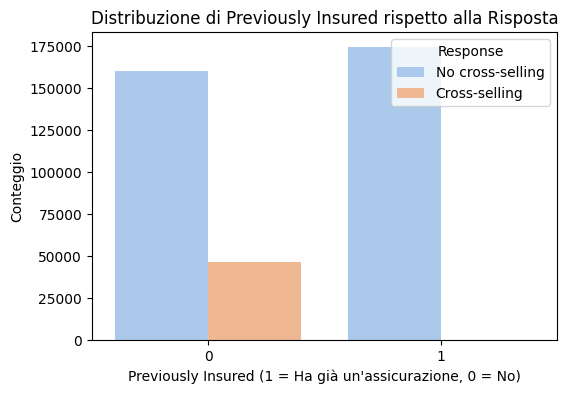

In [ ]:
# Analisi della variabile Previously_Insured
plt.figure(figsize=(6, 4))
hue_labels = {0: "No cross-selling", 1: "Cross-selling"}
sns.countplot(x="Previously_Insured", hue="Response", data=dfencode, palette="pastel")
plt.legend(title="Response", labels=[hue_labels[0], hue_labels[1]])
plt.title("Distribuzione di Previously Insured rispetto alla Risposta")
plt.xlabel("Previously Insured (1 = Ha già un'assicurazione, 0 = No)")
plt.ylabel("Conteggio")
plt.show()

Si osserva visivamente che:
- i casi di risposta positiva al cross-selling diminuiscono quando il cliente in passato aveva sviluppato già una polizza a vita con l'assicurazione

**CONCLUSIONI PRELIMINARE SU VARIABILI CHIAVE**

- Sulla base dei dati forniti si indivia che Annual_Preium ha impatto statisticamente significativo sulla variabile response, ma l'entità è cosi piccola che praticamente presa da sola non avrebbe nessun impatto pratico
- Secondo i modelli di regressione logistica, per ciò che concerne il fatto di essere predentemente assicurati, abbassa la probabilità di avere cross selling perchè il coefficiente è estratto di Previosly_Insured è un moltiplicativo prossimo a 0 alla probablità di ottenere il response pari a 1, del tutto ininfluente. Questo risultato è in accordo con il coefficiente di correlazione linare con il target (correlazione lin. Pearson Pre.In vs Response = 0.-34).
- I proprietari con veicoli con precedenti di incidenti, accettano con maggiore probabilità proposte di cross-selling, cosi come l'anzianità del veicolo risulta un fattore cruciale: sembrano esserci più accettazioni di cross-selling per veicoli con età compresa fra 1 e 2 anni.
-  L'età del veicolo e la possibilità che lo stesso sia precendetemente incidentato cammina di pari passo;
- L'età dell'assicurato è anche correlata positivamente con l'età del veicolo, e dal test t eseguito sull'età della clientela condizionata per classi di Response si osserva la mediana d'eta della clientela della classe response=1 è più anzianda di circa 5 anni

**IN CONCLUSIONE** <br>
- Non esiste una relazione fra Annual Premium vs Response, mentre esiste fra il target e le variabili Vehicle Age e Previously_Insured:
- clienti con macchine più vecchie triplicano in media la probabilità di Risposta positiva al cross selling per ogni classe di età del mezzo anziano
- clienti precedentemente assicurati con Assure predict hanno meno probabilità di sottoscrivere una polizza

-L'età sembra risultare un fattore determinante nella risposta al cross-selling, indicando che ci siano maggiori probabilità di cross-selling assicurativo per la clientela più anziana

# 10 . **CREAZIONE DEL MODELLO MULTIVARIATO DI REGRESSIONE LOGISTICA** <br> **(apprendimento supervisionato con PIPELINE)**

Nelle sezioni precedenti abbiamo esplorato la natura delle variabili e le relazioni delle più importanti in relazione alla variabile risposta, traendo informazioni importanti su azioni *Assurpredit* protrebbe intraprendere per aumentare il tassi di cross selling ed ottimizzare le vendite di tipo cross-sell delle proprie assicurazioni. <br>

In questa sezione invece andremo a sviluppare il migliore modello predittivo di regressione logistica binaria, che possa permettere all'assicurazione di avere uno strumento statistico-matematico che le permetta di prevedere il *profilo responsivo* di nuovi clienti sulla base dei dati di mercato che ha raccolto ed inseriti nel dataset cross-selling.csv.

<br>iniziamo con il creare una copia del dataset finora costruito, rinominando la nuova copia di dfencode in **dflog**:

In [ ]:
dflog=dfencode.copy()
dflog

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,1,44,1,28.0,0,3,1,40454.0,26.0,217,1
2,1,76,1,-1.0,0,2,0,33536.0,26.0,183,0
3,1,47,1,28.0,0,3,1,38294.0,26.0,27,1
4,1,21,1,-1.0,1,1,0,28619.0,152.0,203,0
5,0,29,1,41.0,1,1,0,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
381105,1,74,1,-1.0,1,2,0,30170.0,26.0,88,0
381106,1,30,1,-1.0,1,1,0,40016.0,152.0,131,0
381107,1,21,1,30.0,1,1,0,35118.0,160.0,161,0


In [ ]:
dflog["Response"].value_counts(normalize=True).round(2)

,proportion
Response,
0,0.88
1,0.12


come visto in precedenza il dataset delle risposte risulta essere sbilanciato a favore della risposta 0. Nelle fasi successive di addestramento supervisionato, terremo conto di tale sbilanciamento applicando come fatto in precendenza tutte le tecniche di correzione di peso del caso. Dato che il dataset da dover addestrare contiene 381109 osservazioni e 11 features (incluso *Response*), per favorire i processi di convergenza dei modelli di regressione logistica multivariati è necessario **standardizzare** opprtunamente le variabili numeriche continue. <br>
Quindi, di seguito, **verrà creato il modello di regressione logistica (model)**, previa standardizzazioni delle variabili numeriche e calcolate le previsioni del modello:

## 10 .1 **Random oversampling (classe minoritaria 1)**

**Controllo della pipeline:**

- Split dei dati con stratificazione
- Applicazione del resampling solo sul training set
Standardizzazione: fit_transform sul - training set resampled e transform sul test set
- Addestramento del modello sul training set resampled standardizzato
- Previsioni sul test set standardizzato

valutiamo ora le metriche del modello sul set di dati di **addestramento (TRAIN SET)**


Report di classificazione TRAIN 
               precision    recall  f1-score   support

           0       0.96      0.59      0.73     37368
           1       0.70      0.98      0.82     37368

    accuracy                           0.78     74736
   macro avg       0.83      0.78      0.77     74736
weighted avg       0.83      0.78      0.77     74736


Report di classificazione TEST 
               precision    recall  f1-score   support

           0       0.99      0.59      0.74     66880
           1       0.25      0.97      0.40      9342

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222



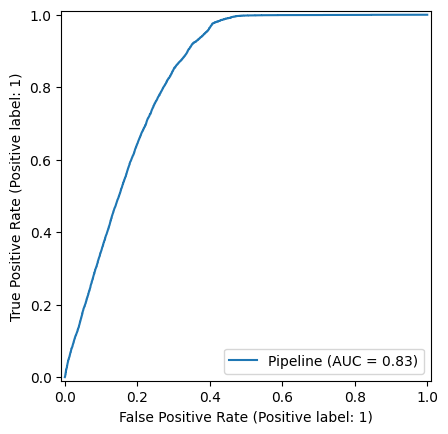

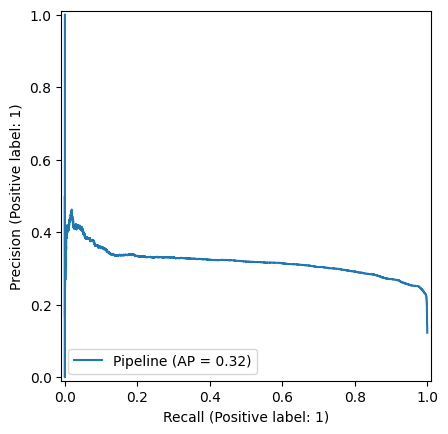

In [ ]:
dflog=dfencode.copy()
dflog
#standardizzazione features
col_to_std = ["Age","Vehicle_Age","Annual_Premium", "Vintage"]
preprocessor = ColumnTransformer(transformers=[("scaler", StandardScaler(), col_to_std)],
                                 remainder="passthrough")  # <- Mantiene le colonne non trasformate
# Dividi i dati in train e test
X = dflog.drop("Response", axis=1)
y = dflog["Response"]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=RANDOM_SEED,
                                                    stratify=y) #<- assicura che nel caso di classi di risposta sbilanciata, fra train e test set si mantengano lo stesse proporzioni delle classi di risposta
#resampler
resampler = RandomOverSampler(random_state=RANDOM_SEED)
X_train, y_train = rus.fit_resample(X_train, y_train) #<- il resampling è stato effettutato dopo lo split e solo sul set di dati di addestramento (x non introdurre bias in fase di validazione)
# Crea la pipeline che combina preprocessing e modello
pipeline = make_pipeline(preprocessor,LogisticRegression(max_iter=500))
#TRAINING MODELLO
pipeline.fit(X_train, y_train)
#PREVISIONI/TEST MODELLO
y_pred_train = pipeline.predict(X_train)
y_proba_train = pipeline.predict_proba(X_train)
y_pred_test = pipeline.predict(X_test)
y_proba_test = pipeline.predict_proba(X_test)
#REPORT CLASSIFICAZIONE
print("\nReport di classificazione TRAIN \n", classification_report(y_train, y_pred_train))
print("\nReport di classificazione TEST \n", classification_report(y_test, y_pred_test))
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()

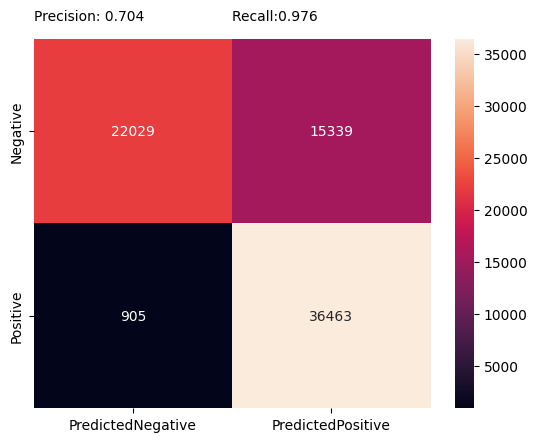

In [ ]:
#VALUTIAMO LE IL REPORT LA MATRICE DI CONFUSIONE SU TRAIN SET
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True)
plt.show()

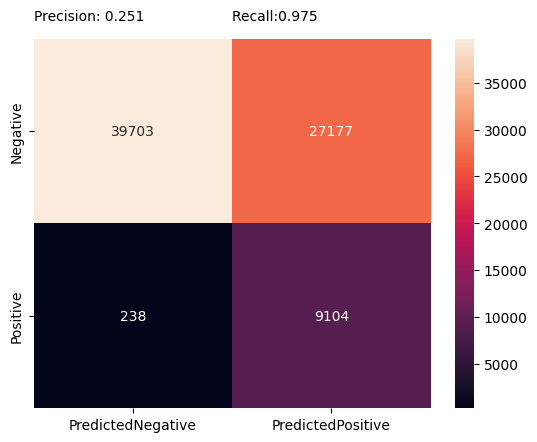

In [ ]:
#VALUTIAMO LE IL REPORT LA MATRICE DI CONFUSIONE SU TEST SET
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True)
plt.show()

## **10.2 - RANDOM Oversampling/Undersampling combinato SMOTETomek**


Report di classificazione TRAIN 
               precision    recall  f1-score   support

           0       0.96      0.59      0.73     37368
           1       0.70      0.98      0.82     37368

    accuracy                           0.78     74736
   macro avg       0.83      0.78      0.77     74736
weighted avg       0.83      0.78      0.77     74736


Report di classificazione TEST 
               precision    recall  f1-score   support

           0       0.99      0.59      0.74     66880
           1       0.25      0.97      0.40      9342

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222



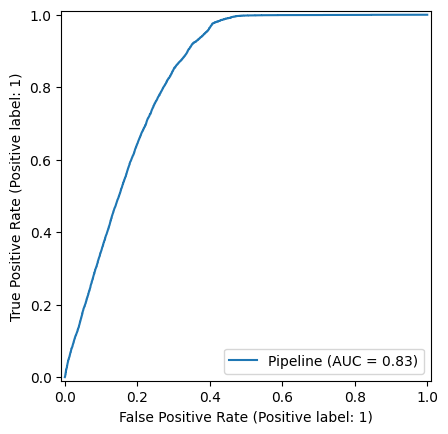

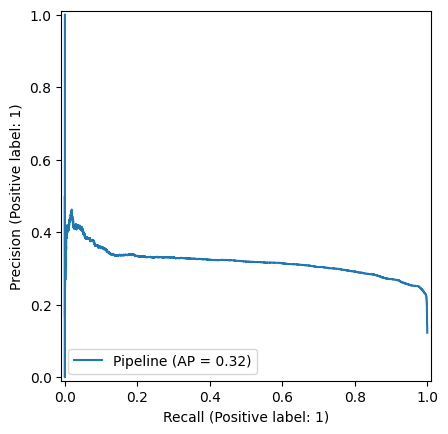

In [ ]:
dflog=dfencode.copy()
dflog
#standardizzazione features
col_to_std = ["Age","Vehicle_Age","Annual_Premium", "Vintage"]
preprocessor = ColumnTransformer(transformers=[("scaler", StandardScaler(), col_to_std)],
                                 remainder="passthrough")  # <- Mantiene le colonne non trasformate
# Dividi i dati in train e test
X = dflog.drop("Response", axis=1)
y = dflog["Response"]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=RANDOM_SEED,
                                                    stratify=y) #<- assicura che nel caso di classi di risposta sbilanciata, fra train e test set si mantengano lo stesse proporzioni delle classi di risposta
#resampler
resampler = SMOTETomek(random_state=RANDOM_SEED)
X_train, y_train = rus.fit_resample(X_train, y_train) #<- il resampling è stato effettutato dopo lo split e solo sul set di dati di addestramento (x non introdurre bias in fase di validazione)
# Crea la pipeline che combina preprocessing e modello
pipeline = make_pipeline(preprocessor,LogisticRegression(max_iter=500))
#TRAINING MODELLO
pipeline.fit(X_train, y_train)
#PREVISIONI/TEST MODELLO
y_pred_train = pipeline.predict(X_train)
y_proba_train = pipeline.predict_proba(X_train)
y_pred_test = pipeline.predict(X_test)
y_proba_test = pipeline.predict_proba(X_test)
#REPORT CLASSIFICAZIONE
print("\nReport di classificazione TRAIN \n", classification_report(y_train, y_pred_train))
print("\nReport di classificazione TEST \n", classification_report(y_test, y_pred_test))
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()

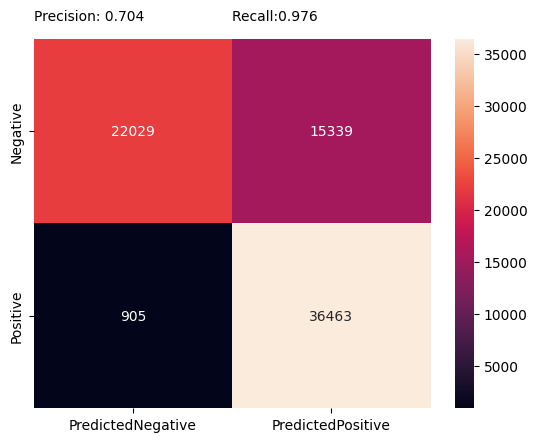

In [ ]:
#VALUTIAMO LE IL REPORT LA MATRICE DI CONFUSIONE SU TRAIN SET
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True)
plt.show()

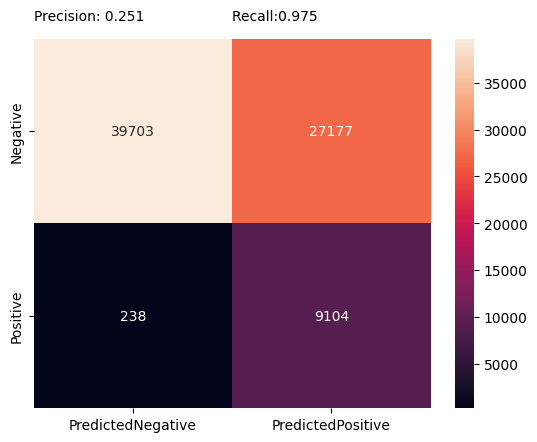

In [ ]:
#VALUTIAMO LE IL REPORT LA MATRICE DI CONFUSIONE SU TEST SET
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True)
plt.show()

## 10.3 **Random undersampling (classe maggioritaria 0)**

---




Report di classificazione TRAIN 
               precision    recall  f1-score   support

           0       0.96      0.59      0.73     37368
           1       0.70      0.98      0.82     37368

    accuracy                           0.78     74736
   macro avg       0.83      0.78      0.77     74736
weighted avg       0.83      0.78      0.77     74736


Report di classificazione TEST 
               precision    recall  f1-score   support

           0       0.99      0.59      0.74     66880
           1       0.25      0.97      0.40      9342

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222



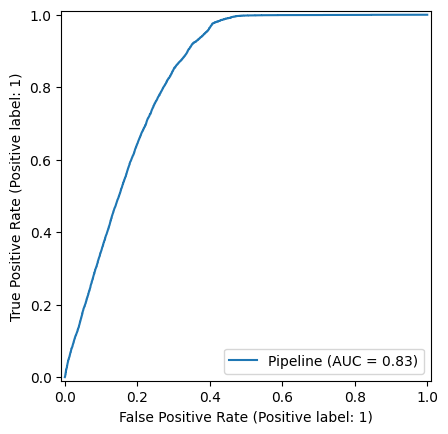

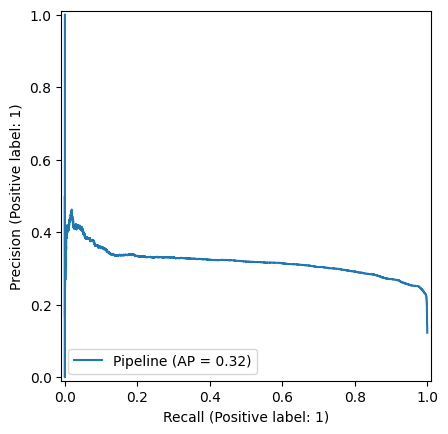

In [ ]:
dflog=dfencode.copy()
dflog
#standardizzazione features
col_to_std = ["Age","Vehicle_Age","Annual_Premium", "Vintage"]
preprocessor = ColumnTransformer(transformers=[("scaler", StandardScaler(), col_to_std)],
                                 remainder="passthrough")  # <- Mantiene le colonne non trasformate
# Dividi i dati in train e test
X = dflog.drop("Response", axis=1)
y = dflog["Response"]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=RANDOM_SEED,
                                                    stratify=y) #<- assicura che nel caso di classi di risposta sbilanciata, fra train e test set si mantengano lo stesse proporzioni delle classi di risposta
#resampler
resampler = RandomUnderSampler(random_state=RANDOM_SEED)
X_train, y_train = rus.fit_resample(X_train, y_train) #<- il resampling è stato effettutato dopo lo split e solo sul set di dati di addestramento (x non introdurre bias in fase di validazione)
# Crea la pipeline che combina preprocessing e modello
pipeline = make_pipeline(preprocessor,LogisticRegression(max_iter=500))
#TRAINING MODELLO
pipeline.fit(X_train, y_train)
#PREVISIONI/TEST MODELLO
y_pred_train = pipeline.predict(X_train)
y_proba_train = pipeline.predict_proba(X_train)
y_pred_test = pipeline.predict(X_test)
y_proba_test = pipeline.predict_proba(X_test)
#REPORT CLASSIFICAZIONE
print("\nReport di classificazione TRAIN \n", classification_report(y_train, y_pred_train))
print("\nReport di classificazione TEST \n", classification_report(y_test, y_pred_test))
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()

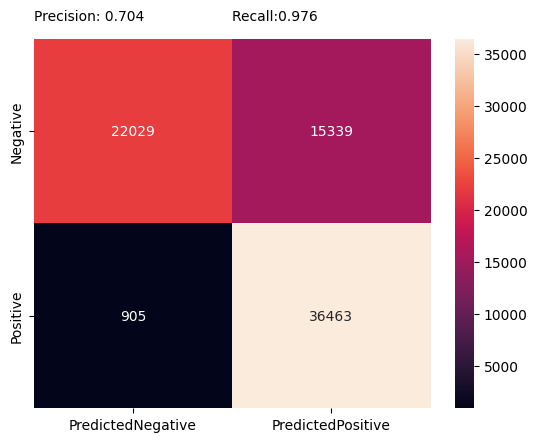

In [ ]:
#VALUTIAMO LE IL REPORT LA MATRICE DI CONFUSIONE SU TRAIN SET
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True)
plt.show()

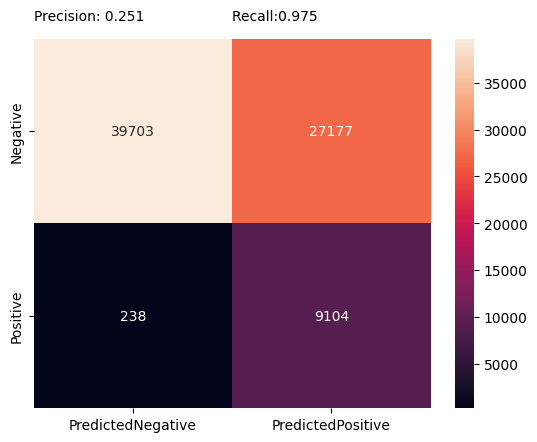

In [ ]:
#VALUTIAMO LE IL REPORT LA MATRICE DI CONFUSIONE SU TEST SET
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True)
plt.show()

**CONSIDERAZIONI**
I modelli di regressioni logistica presentavano problemi di sbilanciamento delle classi di risposta, motivo per cui sono state implementate delle tecniche di pre-bilanciamento del dataset risposte per rendere più equilibrate le predizioni del modello e favorire gli insight dello stesso. Le tecniche impiegate sono state in ordine:
1.   **Random oversampling della classe minoritaria (Response=1) - tecnica 10.1** dove sostanzialmente si replicavano nel dataset ibrido le osservazioni con con riposta 1, bilanciando numericamente le risposte;
2. **SMOTETomek (Random Oversampling Response1 e UnderSampling classe0) - tecnica 10.2**, bilanciamento delle risposte, nel quale si adopera un approccio combinato di oversampling della classe minoritaria 1 e contemporaneamente undersampling della classe maggioritaria 0;
3. **Random undersampling della classe maggioritaria (Response=0) - tecnica 10.3** metoto con il quale è stato ribilanciato il dataset delle risposte effettuando un sottodimensionamento delle risposte positive, in modo che il modello abbia una visione più bilanciata del dataset.<br>
I bilanciamenti con le 3 tecniche differenti hanno sortito in grosso modo gli stessi effetti sulla capacità del modello di effettuare predizioni e nel particolare si hanno avuto le seguenti prestazioni descritte dalle metriche dei modelli. Per semplicita, date le prestazioni simili fra le varie tecniche, prendiamo le metriche di performance del modello di regressione logistica ribilanciato con la tecnica 10.3 (undersampling classe 0), e nello specifico le performance in fase di test:<br><br>

- Classe 0 (No cross-selling):<br>
Precisione: 0.99<br>
Recall: 0.59<br>
F1-score: 0.74<br>

- Classe 1 (Cross-selling):<br>
Precisione: 0.25<br>
Recall: 0.97<br>
F1-score: 0.40<br><br>
Accuracy: 0.64<br>

**Osservazioni:**
- Il recall per la **classe 1** è 0.97, il che significa che il modello identifica quasi i casi di cross-selling, ma con una precisione relativamente bassa (0.25), quindi ci sono molti falsi positivi. La precisione per la **classe 0** è molto alta (0.99), ma il recall è basso (0.59), il che significa che molti casi di "no cross-selling" vengono classificati erroneamente come cross-selling. **L'accuracy score generale del modello 0.64**, quindi in media, è più performante di un classificatore causale di classi nel prevedere detereminate risposte di cross selling 0 o 1.

dato che la precisione nel riconoscere la classe 1 è bassa nel modello, studiamo come l'aumento del threshold possa contribuire ad una migliore efficienza del modello a riconoscere la classe positiva 1

### 10.3.1 **Threeshold Tuning Random Undersampling (classe maggioritaria 0)**

Inserito nel contesto reale, è necessario affrontare diverse esigenze, tra cui valutare i pro e i contro derivanti dall'applicazione delle decisioni basate sui dati. In particolare, in questo caso di cross selling, sarebbe opportuno effettuare una taratura adeguata delle soglie decisionali, affinché il modello possa scegliere correttamente se classificare una risposta come positiva o negativa.

Il **threshold tuning (o regolazione della soglia di decisione)** è una tecnica utilizzata per ottimizzare le prestazioni di un modello di classificazione, come la regressione logistica, modificando la soglia a cui viene presa la decisione tra una classe e l'altra. In un modello di classificazione come la regressione logistica, il modello restituisce una probabilità (tra 0 e 1) che un'istanza appartenga a una certa classe (ad esempio, classe 1: cross-selling).

Per **default, la soglia di decisione è 0.5**: se la probabilità è ≥ 0.5, l'istanza viene classificata come classe 1; altrimenti, come classe 0. Tuttavia, questa soglia può essere regolata per migliorare le prestazioni del modello in base alle esigenze specifiche. La scelta della soglia influisce direttamente su precisione e recall:

- **Aumentare la soglia (es. da 0.5 a 0.7)**= il modello diventa più "cauto" nel classificare un'istanza come classe 1. Aumenta la precisione (meno falsi positivi), ma diminuisce il recall (più falsi negativi).

- **Diminuire la soglia (es. da 0.5 a 0.3)**= Il modello diventa più "aggressivo" nel classificare un'istanza come classe 1. Aumenta il recall (meno falsi negativi), ma diminuisce la precisione (più falsi positivi).

Per regolare praticamente su python i valori di soglia,  si ricostruisce l'array della variabile di risposta (di test) , prendendo solo i valori che soddisfano i requisiti di soglia (espressi in funzione di disequazione), e quindi si ricalcolano le metriche viste sopra:

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
for threshold in [0.1, 0.5,0.65,0.8]:
    y_pred_test = (pipeline.predict_proba(X_test)[:,1] > threshold).astype(int)
    print(f"Threshold: {threshold}")
    print(classification_report(y_test, y_pred_test))

Threshold: 0.1
              precision    recall  f1-score   support

           0       1.00      0.52      0.69     66880
           1       0.23      1.00      0.37      9342

    accuracy                           0.58     76222
   macro avg       0.61      0.76      0.53     76222
weighted avg       0.90      0.58      0.65     76222

Threshold: 0.5
              precision    recall  f1-score   support

           0       0.99      0.59      0.74     66880
           1       0.25      0.97      0.40      9342

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222

Threshold: 0.65
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     66880
           1       0.30      0.77      0.43      9342

    accuracy                           0.75     76222
   macro avg       0.63      0.76      0.63     76222
weighted avg       0.88     

Si osserva che la variazione del valore di soglia decisionale applicata a y_pred_test, considerata ai livelli (0.1, 0.5, 0.65, 0.70), comporta un cambiamento nelle metriche di performance del modello di regressione logistica multivariata. È importante notare che, con una **soglia di 0.65 per la classe di risposta 1**, il modello raggiunge il **miglior compromesso tra precision e recall**, con una media armonica F1 pari a 0.84 per la classe 0 e 0.43 per la classe 1, a indicare un buon equilibrio complessivo.

**Strategie di Ottimizzazione del Cross-Selling** <br>
A seconda del contesto di business, l’azienda, disponendo del modello di regressione logistica, potrà regolare la soglia decisionale in funzione delle strategie adottate, consapevole che ogni variazione influisce in modo diverso sulle prestazioni del classificatore.

**Massimizzare la Precision (aumento della soglia decisionale: threshold > 0.5)**
Se il costo di proporre un’offerta a un cliente non interessato è elevato, è preferibile agire con maggiore cautela prima di effettuare la proposta (es. prodotti di lusso, servizi esclusivi).

**Massimizzare il Recall (riduzione della soglia decisionale: threshold < 0.5)**
Quando è prioritario cogliere tutte le opportunità di vendita, si accetta di proporre offerte anche a clienti meno propensi all’acquisto (es. prodotti di largo consumo, upselling su abbonamenti).


##  10.4 - Modello SUPERVISIONATO CROSS VALIDATION K-FOLD (UNDER SAMPLING CLASSE 0)

- tuning degli iperparametri:

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Definizione delle colonne da standardizzare (esempio con indici)
#col_to_std = [1, 5, 7, 9]
col_to_std = [1, 4, 6, 8]

# Preprocessor: standardizza solo le colonne selezionate
preprocessor = ColumnTransformer(
    transformers=[("scaler", StandardScaler(), col_to_std)],
    remainder="passthrough"
)

# Creazione della pipeline che include il preprocessing, l'under-sampling e il classificatore
pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("undersampler", RandomUnderSampler(random_state=RANDOM_SEED)),
    ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Definizione della griglia degli iperparametri
param_grid = {
    "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "classifier__solver": ["liblinear", "lbfgs", "sag", "saga"]
}

# Definizione della strategia di cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Configurazione di GridSearchCV (oppure, per dataset molto grandi, RandomizedSearchCV)
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring="f1",   # metriche possibili: 'accuracy', 'roc_auc', ecc.
    n_jobs=-1
)

# Esecuzione della Grid Search
grid_search.fit(X, y)

# Output dei risultati
print("Migliori iperparametri:", grid_search.best_params_)
print("Miglior punteggio CV:", grid_search.best_score_)

Migliori iperparametri: {'classifier__C': 100, 'classifier__solver': 'lbfgs'}
Miglior punteggio CV: 0.3984948837274223


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- **KFOLD** (FOLD=5, SmoteTomekm, max_iter=1000, solver="lbfgs", C=10) con Region code
- **KFOLD** (FOLD=5, RandomUnderSampler, max_iter=1000, solver="lbfgs", C=100) senza Region code

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline  # Pipeline compatibile con resampling
dflog=dfencode.copy()
dflog.nunique()
dflog=dflog.drop(["Region_Code"], axis=1)
# Copia del DataFrame e definizione di X e y
X = dflog.drop("Response", axis=1).values
y = dflog["Response"].values
# Definizione delle colonne da scalare (gli indici corrispondono alle colonne "age", "vehicle_age", "annual_premium", "vintage")
age, vehicle_age, annual_premium, vintage = 1, 4, 6, 8
col_to_std = [age, vehicle_age, annual_premium, vintage]
# Preprocessing: scaling solo sulle colonne specificate
preprocessor = ColumnTransformer(
    transformers=[("scaler", StandardScaler(), col_to_std)],
    remainder="passthrough")
# Definizione degli step della pipeline con i migliori iperparametri
pipeline = ImbPipeline(steps=[
    ("preprocessing", preprocessor),
    ("undersampling", RandomUnderSampler(random_state=RANDOM_SEED)),
    ("classifier", LogisticRegression(max_iter=1000, solver="lbfgs", C=100))])
# Setup della cross-validation stratificata (5-fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# Definizione delle metriche di valutazione
scoring = ["accuracy", "precision", "recall", "f1"]
# Esecuzione della cross-validation
cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_train_score=True)
# Visualizzazione dei risultati medi per ciascuna metrica
for metric in scoring:
    print(f"\n{metric.upper()}:")
    print(f"Train: {cv_results[f'train_{metric}'].mean():.4f} ± {cv_results[f'train_{metric}'].std():.4f}")
    print(f"Test:  {cv_results[f'test_{metric}'].mean():.4f} ± {cv_results[f'test_{metric}'].std():.4f}")


ACCURACY:
Train: 0.6393 ± 0.0006
Test:  0.6393 ± 0.0022

PRECISION:
Train: 0.2505 ± 0.0003
Test:  0.2505 ± 0.0012

RECALL:
Train: 0.9756 ± 0.0007
Test:  0.9756 ± 0.0021

F1:
Train: 0.3987 ± 0.0004
Test:  0.3987 ± 0.0015


## 10.5 **ALGORITMO XGBOOST**

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

# Copia del DataFrame e definizione di X e y
dflog = dfencode.copy()
X = dflog.drop("Response", axis=1).values
y = dflog["Response"].values

# Definizione delle colonne da scalare (es. indici: age, vehicle_age, annual_premium, vintage)
age, vehicle_age, annual_premium, vintage = 1, 5, 7, 9
col_to_std = [age, vehicle_age, annual_premium, vintage]

# Preprocessing: scaling sulle colonne specificate
preprocessor = ColumnTransformer(
    transformers=[("scaler", StandardScaler(), col_to_std)],
    remainder="passthrough"
)

# Creazione della pipeline con resampling e XGBoost
pipeline = ImbPipeline(steps=[
    ("preprocessing", preprocessor),
    ("resampling", SMOTETomek(random_state=RANDOM_SEED)),
    ("classifier", XGBClassifier(
        n_estimators=100,          # numero di alberi
        learning_rate=0.1,         # tasso di apprendimento
        max_depth=5,               # profondità massima degli alberi
        use_label_encoder=False,   # da impostare per XGBoost 1.3+
        eval_metric="logloss",     # metrica di valutazione
        random_state=RANDOM_SEED
    ))
])

# Setup della validazione incrociata stratificata (5-fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Definizione delle metriche di valutazione
scoring = ["accuracy", "precision", "recall", "f1"]

# Esecuzione della cross-validation
cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_train_score=True, n_jobs=-1)

# Visualizzazione dei risultati medi per ciascuna metrica
for metric in scoring:
    print(f"\n{metric.upper()}:")
    print(f"Train: {cv_results[f'train_{metric}'].mean():.4f} ± {cv_results[f'train_{metric}'].std():.4f}")
    print(f"Test:  {cv_results[f'test_{metric}'].mean():.4f} ± {cv_results[f'test_{metric}'].std():.4f}")


ACCURACY:
Train: 0.7207 ± 0.0033
Test:  0.7202 ± 0.0020

PRECISION:
Train: 0.2917 ± 0.0017
Test:  0.2909 ± 0.0008

RECALL:
Train: 0.8954 ± 0.0065
Test:  0.8923 ± 0.0055

F1:
Train: 0.4400 ± 0.0012
Test:  0.4387 ± 0.0003
